# Imports

In [1]:
# Miscellaneous (track program progress and so on)
import os
import time
from   datetime import timedelta
import sys
sys.path.append("..") # So it's possible to retrieve packages at a higher top level. (than the directory where the notebook is running)

# Math imports
import math
import numpy as np
import random

# Visualization imports
import matplotlib as plt
from   ipywidgets import interact, fixed
from   IPython.display import clear_output

# Saving/loading, memory optim imports
import pickle
import hashlib

# NLP imports
from   allennlp.data.tokenizers.word_tokenizer import WordTokenizer
# from   allennlp.predictors.predictor import Predictor
# predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/ner-model-2018.12.18.tar.gz")
# predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/fine-grained-ner-model-elmo-2018.12.21.tar.gz")
import re

# Own imports
from helpers.general_helpers import pretty_dict_json_dump, pretty_dict_json_load, join_path, get_path_components
from datasets.preprocessing.uw_re_uva import create_splits_for_masking_types, create_all_capped_masked_data

# Paths

In [2]:
path_datasets = join_path(["..", "datasets" , "Data"])
path_levy     = join_path([path_datasets, "Levy"])
path_ours     = join_path([path_datasets, "Ours"])

levy_full_dataset_path = join_path([path_levy, 'positive_examples'])

path_relation_names = join_path([path_ours, "relation_names.txt"])
path_relation_descriptions = join_path([path_ours, "relations_descriptions"])# + each relation's name
path_proposed_splits = join_path([path_ours, "proposed_splits"])
path_proposed_splits_new = join_path([path_ours, "proposed_splits_new"])
path_proposed_splits_masking = join_path([path_ours, "proposed_splits_masking"])
path_proposed_splits_original = join_path([path_proposed_splits, "original"])
path_proposed_splits_original_new = join_path([path_proposed_splits_new, "original"])
path_proposed_splits_original_masking = join_path([path_proposed_splits_masking, "original"])

# Load relation names from file.
relation_list = []

with open(path_relation_names, "r", encoding='utf-8') as f:
    for line in f:
        relation_list.append(line.strip())

# Helper Functions

In [3]:
# Allows to get the number of lines (and, hence, instances) in a file.
def file_len(fname):
    with open(fname, "r", encoding='utf-8') as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [4]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [5]:
###########################################################################
## ELMO computes embeddings on pre-tokenized, space separated sentences! ##
###########################################################################
tokenizer = WordTokenizer()

# Tokenize with a space between tokens.
def space_word_tokenize_string(s, tokenizer):
    tokenized_string = [token.text for token in tokenizer.tokenize(s)]
    sentence = []
    for k, token in enumerate(tokenized_string):
        sentence += [token] + ([' '] if k + 1 < len(tokenized_string) else [])
    return sentence

# Tokenize in a way that matches AllenNLP's NER predictor.
def NER_space_word_tokenize_string(s, tokenizer):
    split_s = s.split()
    sentence = []
    for k, split_s_ele in enumerate(split_s):
        sentence += [token.text for token in tokenizer.tokenize(split_s_ele)]
        if (k + 1 < len(split_s)):
            sentence += [' ']
    return sentence

# Extract Data from Levy

In [6]:
# For printing purposes, we also get the number of lines present in Levy's positive examples.
NUM_LINES_POSITIVE = file_len(levy_full_dataset_path)

# We define a maximum (tokenized) sentence length.
max_sentence_length = 60

### Damage Assessement

#### Start by aligning all sentences used to create the splits

In [33]:
masking_types = ['original', 'sub_obj_masking', 'NER_masking']

paired_final_sentences = [[], [], []]

for relation in relation_list:
    for m_num, masking_type in enumerate(masking_types):
        with open(join_path([path_ours, "Levy_by_relation", "max_tokenized_sentence_len_60_exclusive_and_unique_relation_masking",
                             masking_type, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']), 'r', encoding="utf-8") as f:
            for l_num, line in enumerate(f):
                line_temp = line.strip()
                paired_final_sentences[m_num].append(line_temp.split("\t")[0] if masking_type == 'original' else line_temp)

paired_final_sentences = list(zip(paired_final_sentences[0], paired_final_sentences[1], paired_final_sentences[2]))
print(len(paired_final_sentences))

996361


In [37]:
sentences_to_relations = {}
annotated_sentences_to_relations = {}

l_num = 0
for relation in relation_list:
    with open(join_path([path_ours, "Levy_by_relation", "max_tokenized_sentence_len_60",
                         re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']), 'r', encoding="utf-8") as f:
        for line in f:
            if (l_num % 500 == 0 or l_num + 1 == lines_before):
                print('\r' + '{:6.2f}%'.format(100*(l_num)/lines_before), end="", flush=True)
            l_num += 1

            line_temp = line.strip().split("\t")
            original_sentence = line_temp[0]
            
            if original_sentence not in sentences_to_relations:
                sentences_to_relations[original_sentence] = set()
            sentences_to_relations[original_sentence].add(relation)

            # We assume the first entity is the subject entity and that the second one is the object entity.
            # Any other entities are disregarded.
            tokenized_sentence = space_word_tokenize_string(line_temp[0], tokenizer)
            tokenized_subject_entity = space_word_tokenize_string(line_temp[1], tokenizer)
            tokenized_object_entity = space_word_tokenize_string(line_temp[2], tokenizer)

            masked_sentence = []
            word_pos = 0
            while (word_pos < len(tokenized_sentence)):
                current_word = tokenized_sentence[word_pos]

                match = False
                if (current_word == tokenized_subject_entity[0] or
                        current_word == tokenized_object_entity[0]):
                    # We assume that the subject entity is different from the object entity.
                    # First we start by testing the subject entity.
                    if (word_pos + len(tokenized_subject_entity) <= len(tokenized_sentence)):
                        match = True
                        for subj_word_num, subj_word in enumerate(tokenized_subject_entity):
                            if (subj_word != tokenized_sentence[word_pos + subj_word_num]):
                                match = False
                                break
                        if (match):
                            masked_sentence.append('SUBJECT_ENTITY')
                            word_pos += len(tokenized_subject_entity)

                    # Now we test the object entity.
                    if (not match and word_pos + len(tokenized_object_entity) <= len(tokenized_sentence)):
                        match = True
                        for obj_word_num, obj_word in enumerate(tokenized_object_entity):
                            if (obj_word != tokenized_sentence[word_pos + obj_word_num]):
                                match = False
                                break
                        if (match):
                            masked_sentence.append('OBJECT_ENTITY')
                            word_pos += len(tokenized_object_entity)

                if (not match):
                    masked_sentence.append(tokenized_sentence[word_pos])
                    word_pos += 1

            masked_sentence = ''.join(masked_sentence)
            if masked_sentence not in annotated_sentences_to_relations:
                annotated_sentences_to_relations[masked_sentence] = set()
            annotated_sentences_to_relations[masked_sentence].add(relation)

num_unique_sentences = len(sentences_to_relations)
num_sentences_with_more_relations = sum(len(sentences_to_relations[sentence]) > 1 for sentence in sentences_to_relations)

print("\n")
print(num_unique_sentences, num_sentences_with_more_relations, 100*num_sentences_with_more_relations/num_unique_sentences)

print("\n\n\n")

num_unique_annotated_sentences = len(annotated_sentences_to_relations)
num_annotated_sentences_with_more_relations = sum(len(annotated_sentences_to_relations[masked_sentence]) > 1 for masked_sentence in annotated_sentences_to_relations)

print("\n")
print(num_unique_annotated_sentences, num_annotated_sentences_with_more_relations, 100*num_annotated_sentences_with_more_relations/num_unique_annotated_sentences)

100.00%

1478736 589248 39.84808647385334






1944829 29597 1.5218304539884997


In [42]:
num_final_sentences = len(paired_final_sentences)
num_sentences_with_more_relations = sum(len(sentences_to_relations[sentence]) > 1 for sentence, _, _ in paired_final_sentences)
print(num_final_sentences, num_sentences_with_more_relations, 100*num_sentences_with_more_relations/num_final_sentences)

print("\n")

num_annotated_sentences_with_more_relations = sum(len(annotated_sentences_to_relations[sub_obj_sent]) > 1 for _, sub_obj_sent, _ in paired_final_sentences)

print(num_final_sentences, num_annotated_sentences_with_more_relations, 100*num_annotated_sentences_with_more_relations/num_final_sentences)

996361 404580 40.60576437656633


996361 23367 2.345234307645522


In [15]:
lines_before = sum(file_len(join_path([path_ours, "Levy_by_relation", "max_tokenized_sentence_len_60",
                                       re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'])) for relation in relation_list)

lines_after = sum(file_len(join_path([path_ours, "Levy_by_relation", "max_tokenized_sentence_len_60_exclusive_and_unique_relation",
                                      "NER_masking", re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'])) for relation in relation_list)

print(lines_before, lines_after)

2314975 1472278


In [16]:
annotated_sentences_to_relations = {}

l_num = 0
for relation in relation_list:
    with open(join_path([path_ours, "Levy_by_relation", "max_tokenized_sentence_len_60",
                         re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']), 'r', encoding="utf-8") as f:
        for line in f:
            if (l_num % 500 == 0 or l_num + 1 == lines_before):
                print('\r' + '{:6.2f}%'.format(100*(l_num)/lines_before), end="", flush=True)
            l_num += 1

            line_temp = line.strip().split("\t")

            # We assume the first entity is the subject entity and that the second one is the object entity.
            # Any other entities are disregarded.
            tokenized_sentence       = space_word_tokenize_string(line_temp[0], tokenizer)
            tokenized_subject_entity = space_word_tokenize_string(line_temp[1], tokenizer)
            tokenized_object_entity  = space_word_tokenize_string(line_temp[2], tokenizer)

            masked_sentence = []
            word_pos = 0
            while (word_pos < len(tokenized_sentence)):
                current_word = tokenized_sentence[word_pos]

                match = False
                if (current_word == tokenized_subject_entity[0] or
                        current_word == tokenized_object_entity[0]):
                    # We assume that the subject entity is different from the object entity.
                    # First we start by testing the subject entity.
                    if (word_pos + len(tokenized_subject_entity) <= len(tokenized_sentence)):
                        match = True
                        for subj_word_num, subj_word in enumerate(tokenized_subject_entity):
                            if (subj_word != tokenized_sentence[word_pos + subj_word_num]):
                                match = False
                                break
                        if (match):
                            masked_sentence.append('SUBJECT_ENTITY')
                            word_pos += len(tokenized_subject_entity)

                    # Now we test the object entity.
                    if (not match and word_pos + len(tokenized_object_entity) <= len(tokenized_sentence)):
                        match = True
                        for obj_word_num, obj_word in enumerate(tokenized_object_entity):
                            if (obj_word != tokenized_sentence[word_pos + obj_word_num]):
                                match = False
                                break
                        if (match):
                            masked_sentence.append('OBJECT_ENTITY')
                            word_pos += len(tokenized_object_entity)

                if (not match):
                    masked_sentence.append(tokenized_sentence[word_pos])
                    word_pos += 1

            masked_sentence = ''.join(masked_sentence)
            if masked_sentence not in annotated_sentences_to_relations:
                annotated_sentences_to_relations[masked_sentence] = set()
            annotated_sentences_to_relations[masked_sentence].add(relation)

num_unique_sentences = len(annotated_sentences_to_relations)
num_sentences_with_more_relations = sum(len(annotated_sentences_to_relations[masked_sentence]) > 1 for masked_sentence in annotated_sentences_to_relations)

print("\n")
print(num_unique_sentences, num_sentences_with_more_relations, 100*num_sentences_with_more_relations/num_unique_sentences)

100.00%1944829 29597 1.5218304539884997


In [18]:
sentences_to_relations = {}

for relation in relation_list:
    with open(join_path([path_ours, "Levy_by_relation", "max_tokenized_sentence_len_60_exclusive_and_unique_relation",
                         "sub_obj_masking", re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']), 'r', encoding="utf-8") as f:
#     with open(join_path([path_ours, "Levy_by_relation", "max_tokenized_sentence_len_60",
#                      re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']), 'r', encoding="utf-8") as f:
        for line in f:
            sentence = line.strip()
#             line_temp = line.strip().split("\t")
#             sentence = line_temp[0]
#             entity_1 = line_temp[1]
#             entity_2 = line_temp[2]
    
            if sentence not in sentences_to_relations:
                sentences_to_relations[sentence] = set()
            sentences_to_relations[sentence].add(relation)
#             if (sentence, entity_1, entity_2) not in sentences_to_relations:
#                 sentences_to_relations[(sentence, entity_1, entity_2)] = set()
#             sentences_to_relations[(sentence, entity_1, entity_2)].add(relation)

num_unique_sentences = len(sentences_to_relations)
num_sentences_with_more_relations = sum(len(sentences_to_relations[mention]) > 1 for mention in sentences_to_relations)

print(num_unique_sentences, num_sentences_with_more_relations, 100*num_sentences_with_more_relations/num_unique_sentences)

1210977 544 0.04492240562785255


#### We start by counting the total number of unique sentences and unique relation mentions in Levy's dataset.

In [10]:
unique_sentences = set()
unique_relation_mentions = set()

with open(levy_full_dataset_path, "r", encoding='utf-8') as f:

    for l_num, line in enumerate(f):
        if (l_num % 500 == 0 or l_num + 1 == NUM_LINES_POSITIVE):
            print('\r' + '{:6.2f}%'.format(100*(l_num+1)/NUM_LINES_POSITIVE), end="", flush=True)

        line_temp = line.strip().split("\t")

        relation       = line_temp[0]
        subject_entity = line_temp[2]
        sentence       = line_temp[3]
        unique_sentences.add(sentence)
        for object_entity in line_temp[4:]:
            unique_relation_mentions.add((sentence, relation, subject_entity, object_entity))

print()
print("Number of unique sentences:", len(unique_sentences))
print("Number of unique relation mentions:", len(unique_relation_mentions))

100.00%
Number of unique sentences: 1499932
Number of unique relation mentions: 2416256


#### Now we count the same statistics, but for a maximum tokenized sentence length of max_sentence_length.

In [12]:
unique_sentences_max_length = set()
unique_relation_mentions_max_length = set()

with open(levy_full_dataset_path, "r", encoding='utf-8') as f:

    for l_num, line in enumerate(f):
        if (l_num % 500 == 0 or l_num + 1 == NUM_LINES_POSITIVE):
            print('\r' + '{:6.2f}%'.format(100*(l_num+1)/NUM_LINES_POSITIVE), end="", flush=True)

        line_temp = line.strip().split("\t")

        if (len(tokenizer.tokenize(line_temp[3])) <= max_sentence_length):
            relation       = line_temp[0]
            subject_entity = line_temp[2]
            sentence       = line_temp[3]
            unique_sentences_max_length.add(sentence)
            for object_entity in line_temp[4:]:
                unique_relation_mentions_max_length.add((sentence, relation, subject_entity, object_entity))

print()
print("Number of unique sentences:", len(unique_sentences_max_length))
print("Number of unique relation mentions:", len(unique_relation_mentions_max_length))

100.00%
Number of unique sentences: 1478736
Number of unique relation mentions: 2376807


#### We evaluate how many sentences have more than 1 relation mention.

In [17]:
sentence_multiple_mentions = {}
sentence_different_relation_mentions = {}

for sentence, relation, entity_1, entity_2 in unique_relation_mentions_max_length:
    if (sentence) not in sentence_multiple_mentions:
        sentence_multiple_mentions[sentence] = 1
    else:
        sentence_multiple_mentions[sentence] += 1

    if (sentence not in sentence_different_relation_mentions):
        sentence_different_relation_mentions[sentence] = set()
    sentence_different_relation_mentions[sentence].add(relation)

1478736
889488
889488
589248
1425423


In [56]:
print("Number of distinct sentences:", len(sentence_multiple_mentions), len(sentence_multiple_mentions) == len(sentence_different_relation_mentions))
print()

n_sentences_single_mention = sum(sentence_multiple_mentions[sentence] == 1 for sentence in sentence_multiple_mentions)
print("Number of sentences with one single relation mention:", n_sentences_single_mention)
n_sentences_express_single_relation = sum(len(sentence_different_relation_mentions[sentence]) == 1 for sentence in sentence_different_relation_mentions)
print("Number of sentences that express one single relation:", n_sentences_express_single_relation)
n_sentences_single_rel_multiple_mentions = n_sentences_express_single_relation - n_sentences_single_mention
print("Number of sentences that express one single relation, but have multiple mentions:", n_sentences_single_rel_multiple_mentions)
print()

n_sentences_multiple_mentions = sum(sentence_multiple_mentions[sentence] > 20 for sentence in sentence_multiple_mentions)
print("Number of sentences with multiple relation mentions:", n_sentences_multiple_mentions)
n_sentences_express_multiple_relations = sum(len(sentence_different_relation_mentions[sentence]) > 1 for sentence in sentence_different_relation_mentions)
print("Number of sentences that express multiple relations:", n_sentences_express_multiple_relations)
# n_sentences_multiple_rels_multiple_mentions = 
# print("Number of sentences that express multiple relations and have multiple mentions:", n_sentences_express_multiple_relations - n_sentences_multiple_mentions)

# print(len(sentence_different_relation_mentions))
# print(sum(len(sentence_different_relation_mentions[sentence]) == 1 for sentence in sentence_different_relation_mentions))
# print(sum(len(sentence_different_relation_mentions[sentence]) for sentence in sentence_different_relation_mentions
#                                                                   if len(sentence_different_relation_mentions[sentence]) == 1))
# print(sum(len(sentence_different_relation_mentions[sentence]) > 1 for sentence in sentence_different_relation_mentions))
# print(sum(len(sentence_different_relation_mentions[sentence]) for sentence in sentence_different_relation_mentions
#                                                                   if len(sentence_different_relation_mentions[sentence]) > 1))

Number of distinct sentences: 1478736 True

Number of sentences with one single relation mention: 875245
Number of sentences that express one single relation: 889488
Number of sentences that express one single relation, but have multiple mentions: 14243

Number of sentences with multiple relation mentions: 1
Number of sentences that express multiple relations: 589248


#### Here we extract all unique tuples (relation, sentence, entities) that match the maximum length.

In [12]:
# Make sure the "positive_'str(max_sentence_length)'/" Directory exists.
directory = os.path.dirname(path_ours + 'Levy_by_relation/max_tokenized_sentence_len_' + str(max_sentence_length) + '/')
if (not os.path.exists(directory)):
    os.makedirs(directory)

# Open the file pointers for each relation.
relation_filepointers_capped = {}
for relation in relation_list:
    file_name_positive = path_ours + 'Levy_by_relation/max_tokenized_sentence_len_' + str(max_sentence_length) + '/'
    file_name_positive += re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'
    relation_filepointers_capped[relation] = open(file_name_positive, 'w', encoding='utf-8')



num_sentences_without_at_least_two_entities = 0 # Used for statistics.
num_distinct_instances = 0 # Used for statistics.

# Used to make sure that we do not have repeated training instances. Due to multiple questions (the questions in Levy's framework) we
# expect some tuple repetitions.
sentences_hash_dict = {}

with open(levy_full_dataset_path, "r", encoding='utf-8') as f:

    # Used for printing purposes.
    l_num = 0

    # Used to check for repetition.
    current_cursor_value = f.tell()
    line = f.readline()
    next_cursor_position = f.tell()

    while line:
        if (l_num % 500 == 0 or l_num + 1 == NUM_LINES_POSITIVE):
            print('\r' + '{:6.2f}%'.format(100*(l_num+1)/NUM_LINES_POSITIVE), end="", flush=True)
        
        line_temp = line.strip().split("\t")

        # We only want sentences that have at least two entities present, since we are modelling binary relations. From inspection, sentences
        # with more than 2 entities just have that the subject entity relates to every other wntity in the same way, i.e., it has the same relation.
        if (len(line_temp) < 5):
            num_sentences_without_at_least_two_entities += 1

        else:
            # We cap the tokenized sentence length.
            if (len(tokenizer.tokenize(line_temp[3])) <= max_sentence_length):

                relation = line_temp[0]
                sentence = line_temp[3]
                entities = [line_temp[2]] + [line_temp[i] for i in range(4, len(line_temp))]

                # We compute the hash so that the 'sentences_hash_dict' doesn't have to keep the entire sentence around.
                sentence_hash = hashlib.md5(line_temp[3].encode('utf-8')).hexdigest()

                # Check if this is a new training instance.
                new_instance = True
                if (sentence_hash not in sentences_hash_dict):
                    sentences_hash_dict[sentence_hash] = [current_cursor_value]
                else:
                    for previous_sentence_cursor_position in sentences_hash_dict[sentence_hash]:
                        f.seek(previous_sentence_cursor_position)
                        previous_sentence = f.readline()
                        previous_sentence_temp = previous_sentence.strip().split("\t")

                        old_relation = previous_sentence_temp[0]
                        old_sentence = previous_sentence_temp[3]
                        old_entities = [previous_sentence_temp[2]] + [previous_sentence_temp[i] for i in range(4, len(previous_sentence_temp))]

                        # Same sentence?
                        if (sentence == old_sentence):
                            # Same relation?
                            if (relation == old_relation):
                                # Same entities?
                                if (len(entities) == len(old_entities) and all(entities[i] == old_entities[i] for i in range(len(entities)))):
                                    new_instance = False
                                    break

                f.seek(next_cursor_position)
                if (new_instance):
                    num_distinct_instances += 1

                    sentences_hash_dict[sentence_hash].append(current_cursor_value)

                    new_instance = [sentence] + entities
                    for i, data_element in enumerate(new_instance):
                        relation_filepointers_capped[relation].write(data_element + ('\t' if i + 1 < len(new_instance) else '\n'))                                


        l_num += 1
        current_cursor_value = f.tell()
        line = f.readline()
        next_cursor_position = f.tell()


# Close the file pointers.
for relation in relation_filepointers_capped:
    relation_filepointers_capped[relation].close()

print("\n\nDistinct number of instances:", num_distinct_instances)
print("Number of instances without at least 2 entities:", num_sentences_without_at_least_two_entities)

100.00%

Distinct number of instances: 2314975
Number of instances without at least 2 entities: 0


#### Here we get some statistics on those tuples, such as how many instances of the sentences appear in more than one relation and how many sentences appear more than once within the same relation, due to different entities. We also count the number of sentences assigned to each relation.

In [7]:
seen_xs = {}

num_instances = sum(file_len(path_ours + 'Levy_by_relation/max_tokenized_sentence_len_' + str(max_sentence_length) + '/' +
                             re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt') for relation in relation_list)

repeated_xs = 0
repeated_xs_same_relation = 0

l_num = 1
for relation in relation_list:
    file_name_positive = path_ours + 'Levy_by_relation/max_tokenized_sentence_len_' + str(max_sentence_length) + '/'
    file_name_positive += re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'

    with open(file_name_positive, 'r', encoding='utf-8') as f:
        for line in f:
            if (l_num % 500 == 0 or l_num + 1 == num_instances):
                print('\r' + '{:6.2f}%'.format(100*(l_num)/num_instances), end="", flush=True)
            l_num += 1

            x = line.strip().split('\t')[0]
            if (x in seen_xs):
                repeated_xs += 1
                if (relation in seen_xs[x]):
                    repeated_xs_same_relation += 1
                    seen_xs[x][relation] += 1
                else:
                    seen_xs[x][relation] = 1
            else:
                seen_xs[x] = {relation: 1}

print("\n")
print("Number of repetitions, across relation (the same sentence might be repeated more than once):", repeated_xs)
print("Number of sentences that appear more than once in the same relation:", repeated_xs_same_relation)

100.00%

Number of repetitions, across relation (the same sentence might be repeated more than once): 836239
Number of sentences that appear more than once in the same relation: 64


#### We get the data distribution per relation.

In [9]:
# Create a map from index to a tuple that indicates the relation and corresponding number of instances in that relation.
idx_to_relation_and_len = []


# Go over each relation and get the number of instances.
for r_num, relation in enumerate(relation_list):
    file_name_positive = path_ours + 'Levy_by_relation/max_tokenized_sentence_len_' + str(max_sentence_length) + '/'
    file_name_positive += re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'
    idx_to_relation_and_len.append([relation, file_len(file_name_positive)])

# Sort the relations by number of instances, in increasing order.
idx_to_relation_and_len.sort(key=lambda lst: lst[1])
print(sum(lst[1] for lst in idx_to_relation_and_len))
print()
print(idx_to_relation_and_len)

# Create a map from relation to (sorted) index.
relation_to_idx = {relation: idx for idx, (relation, _) in enumerate(idx_to_relation_and_len)}

2314975

[['medical condition', 105], ['architectural style', 110], ['editor', 113], ['nominated for', 115], ['head of government', 126], ['date of official opening', 127], ['military rank', 127], ['time of discovery', 128], ['home venue', 139], ['replaced by', 143], ['instrumentation', 146], ['chairperson', 178], ['operating system', 182], ['product', 183], ['chromosome', 190], ['conferred by', 206], ['sister', 213], ['service entry', 218], ['religious order', 219], ['site of astronomical discovery', 219], ['manner of death', 222], ['convicted of', 228], ['license', 242], ['noble title', 251], ['standards body', 254], ['located next to body of water', 257], ['airline hub', 293], ['film editor', 308], ['illustrator', 326], ['time of spacecraft launch', 344], ['characters', 354], ['canonization status', 368], ['noble family', 392], ['location of formation', 404], ['collection', 414], ['IUCN conservation status', 420], ['drafted by', 440], ['industry', 468], ['based on', 502], ['located 

#### Now, we could allow for the same sentence, x, to be present in multiple relations (probably with different entities involved) or even for the same x to be present more than once for the same relation, for different entities. However, since at test time we do not really know how to mask (as that would mean knowing beforehand which entities are in the relation, which could happen, but is unlikely), we avoid having repeated sentences over the dataset. So, we assign those repeated sentences to the relation with the fewest instances.

In [29]:
# Make sure the "positive_'str(max_sentence_length)'_exclusive_and_unique_relation/" Directory exists.
path_dir_capped = path_ours + 'Levy_by_relation/max_tokenized_sentence_len_' + str(max_sentence_length) + '/'
path_dir_capped_exclusive = path_ours + 'Levy_by_relation/max_tokenized_sentence_len_' + str(max_sentence_length) + '_exclusive_and_unique_relation/'
directory = os.path.dirname(path_dir_capped_exclusive)
if (not os.path.exists(directory)):
    os.makedirs(directory)


relation_filepointers_capped_exclusive = {}

l_num = 1


for relation in relation_list:

    relation_path_capped = path_dir_capped + re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'
    relation_path_capped_exclusive = path_dir_capped_exclusive + re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'

    with open(relation_path_capped_exclusive, 'w', encoding='utf-8') as f_capped_exclusive:
        with open(relation_path_capped, 'r', encoding='utf-8') as f_capped:
            for line in f_capped:
                if (l_num % 500 == 0 or l_num + 1 == num_instances):
                    print('\r' + '{:6.2f}%'.format(100*(l_num)/num_instances), end="", flush=True)
                l_num += 1

                x = line.strip().split('\t')[0]

                try:
                    if (seen_xs[x] != 'DONE'):
                        if (len(seen_xs[x]) == 1):
                            f_capped_exclusive.write(line)
                            idx_to_relation_and_len[relation_to_idx[relation]][1] -= seen_xs[x][relation] - 1
                            seen_xs[x] = 'DONE'

                        else:
                            min_num_insts = np.inf
                            for repeated_inst_rel in seen_xs[x]:
                                if (idx_to_relation_and_len[relation_to_idx[repeated_inst_rel]][1] < min_num_insts):
                                    min_num_insts = idx_to_relation_and_len[relation_to_idx[repeated_inst_rel]][1]
                                    rel_with_fewest_num_insts = repeated_inst_rel

                            if (relation == rel_with_fewest_num_insts):
                                f_capped_exclusive.write(line)

                                for repeated_inst_rel in seen_xs[x]:
                                    if (relation == repeated_inst_rel):
                                        idx_to_relation_and_len[relation_to_idx[repeated_inst_rel]][1] -= seen_xs[x][repeated_inst_rel] - 1
                                    else:
                                        idx_to_relation_and_len[relation_to_idx[repeated_inst_rel]][1] -= seen_xs[x][repeated_inst_rel]
                                seen_xs[x] = 'DONE'
                            else:
                                seen_xs[x][relation] -= 1
                                idx_to_relation_and_len[relation_to_idx[relation]][1] -= 1

                except Exception as err:
                    # Here in case something needs to be printed.
                    raise err



print('\n')
idx_to_relation_and_len.sort(key=lambda lst: lst[1])
print("Total number of unique and exclusive sentences:", sum(lst[1] for lst in idx_to_relation_and_len))
print()
print(idx_to_relation_and_len)

FileNotFoundError: [Errno 2] No such file or directory: '..\\datasets\\Data\\OursLevy_by_relation/max_tokenized_sentence_len_60/IUCN_conservation_status.txt'

#### We also know we'll be running experiments with masking, so we have to guarantee that the masking does not break the uniqueness of the sentences, or else we might break our disjointness assumptions. Here we determine which sentences end up reducing to the same one, after having been masked.

In [35]:
max_sentence_length = 60
path_dir_capped_exclusive = join_path([path_ours, 'Levy_by_relation', 'max_tokenized_sentence_len_' + str(max_sentence_length) + '_exclusive_and_unique_relation'])


idx_to_relation_and_len = []
for relation in relation_list:
    idx_to_relation_and_len.append([relation, file_len(join_path([path_dir_capped_exclusive, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']))])

idx_to_relation_and_len.sort(key=lambda lst: lst[1])
relation_to_idx_map = {relation: r_num for r_num, (relation, _) in enumerate(idx_to_relation_and_len)}
print("Total number of unique and exclusive sentences:", sum(lst[1] for lst in idx_to_relation_and_len))
print()
print(idx_to_relation_and_len)
print('\n\n')
print(relation_to_idx_map)


masking_types = ['original', 'sub_obj_masking', 'NER_masking']

original_data = {}
repeated = {masking_type: {} for masking_type in masking_types}
sentence_id = {masking_type: {} for masking_type in masking_types}

for relation in relation_list:
    for masking_type in masking_types:
        if (masking_type == 'original'):
            path = join_path([path_dir_capped_exclusive, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'])
        else:
            path = join_path([path_dir_capped_exclusive, masking_type, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'])

        with open(path, 'r', encoding='utf-8') as f:
            for l_num, line in enumerate(f):
                sentence = line.strip().split('\t')[0] if masking_type == 'original' else line.strip()
                sentence_id[masking_type][(relation, l_num)] = sentence
                if (sentence not in repeated[masking_type]):
                    repeated[masking_type][sentence] = [(relation, l_num)]
                else:
                    repeated[masking_type][sentence].append((relation, l_num))

Total number of unique and exclusive sentences: 1472278

[['medical condition', 105], ['architectural style', 110], ['editor', 113], ['nominated for', 115], ['replaced by', 125], ['head of government', 126], ['date of official opening', 127], ['military rank', 127], ['time of discovery', 128], ['home venue', 139], ['instrumentation', 146], ['chairperson', 177], ['operating system', 182], ['product', 183], ['chromosome', 190], ['site of astronomical discovery', 195], ['conferred by', 206], ['sister', 212], ['service entry', 218], ['religious order', 219], ['manner of death', 222], ['convicted of', 228], ['license', 238], ['noble title', 251], ['standards body', 254], ['located next to body of water', 257], ['airline hub', 293], ['film editor', 308], ['illustrator', 325], ['time of spacecraft launch', 344], ['characters', 353], ['canonization status', 364], ['noble family', 392], ['location of formation', 404], ['collection', 414], ['IUCN conservation status', 420], ['drafted by', 440], 

In [36]:
included_ids = set()
excluded_ids = set()

for original_sentence_id in sentence_id['original']:
    if (original_sentence_id in excluded_ids):
        continue

    if (len(repeated['sub_obj_masking'][sentence_id['sub_obj_masking'][original_sentence_id]]) > 1 or
        len(repeated['NER_masking'][sentence_id['NER_masking'][original_sentence_id]]) > 1):
        overlap_set = set(repeated['sub_obj_masking'][sentence_id['sub_obj_masking'][original_sentence_id]])
        overlap_set = overlap_set | set(repeated['NER_masking'][sentence_id['NER_masking'][original_sentence_id]])

        min_relation_name = None
        min_relation_instances = np.inf
        for overlap_id in overlap_set:
            if (idx_to_relation_and_len[relation_to_idx_map[overlap_id[0]]][1] < min_relation_instances):
                min_relation_name = overlap_id[0]
                min_relation_instances = idx_to_relation_and_len[relation_to_idx_map[overlap_id[0]]][1]

        if (original_sentence_id[0] == min_relation_name):
            included_ids.add(original_sentence_id)
            for _id in overlap_set:
                if (_id != original_sentence_id):
                    if (_id in included_ids):
                        raise RuntimeError('Adding invalid id to the exclusion set.')
                    if (_id not in excluded_ids):
                        idx_to_relation_and_len[relation_to_idx_map[_id[0]]][1] -= 1
                    excluded_ids.add(_id)
        else:
            if (original_sentence_id not in excluded_ids):
                idx_to_relation_and_len[relation_to_idx_map[original_sentence_id[0]]][1] -= 1
            excluded_ids.add(original_sentence_id)
    else:
        included_ids.add(original_sentence_id)


print("Number of included sentences:", len(included_ids))
print("Number of excluded sentences:", len(excluded_ids))

print(idx_to_relation_and_len)
print('\n\n')
idx_to_relation_and_len.sort(key=lambda lst: lst[1])
print("Total number of unique and exclusive sentences:", sum(lst[1] for lst in idx_to_relation_and_len))
print("Unseen:", sum(counts for _, counts in idx_to_relation_and_len[:60]), "; Seen:", sum(counts for _, counts in idx_to_relation_and_len[60:]))
print()
print(idx_to_relation_and_len)


# Save the unique sentences.
max_sentence_length = 60
path_dir_capped_exclusive_accounting_masking = join_path([path_ours, 'Levy_by_relation',
                                                          'max_tokenized_sentence_len_' + str(max_sentence_length) + '_exclusive_and_unique_relation_masking'])

paths = {}

for masking_type in masking_types:
    paths[masking_type] = {}

    masking_path = join_path([path_dir_capped_exclusive_accounting_masking, masking_type]) + os.sep

    directory = os.path.dirname(masking_path)
    if (not os.path.exists(directory)):
        os.makedirs(directory)

    for relation in relation_list:
        paths[masking_type][relation] = open(join_path([masking_path, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']), 'w', encoding='utf-8')

try:
    for relation in relation_list:
        for masking_type in masking_types:
            if (masking_type == 'original'):
                path = join_path([path_dir_capped_exclusive, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'])
            else:
                path = join_path([path_dir_capped_exclusive, masking_type, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'])

            with open(path, 'r', encoding='utf-8') as f:
                for l_num, line in enumerate(f):
                    if ((relation, l_num) in included_ids):
                        paths[masking_type][relation].write(line.strip() + '\n')
        
except:
    for masking_type in masking_types:
        for relation in relation_list:
            paths[masking_type][relation].close()

for masking_type in masking_types:
    for relation in relation_list:
        paths[masking_type][relation].close()

Number of included sentences: 996361
Number of excluded sentences: 475917
[['medical condition', 103], ['architectural style', 110], ['editor', 96], ['nominated for', 111], ['replaced by', 106], ['head of government', 117], ['date of official opening', 124], ['military rank', 123], ['time of discovery', 128], ['home venue', 96], ['instrumentation', 143], ['chairperson', 177], ['operating system', 182], ['product', 167], ['chromosome', 190], ['site of astronomical discovery', 183], ['conferred by', 205], ['sister', 211], ['service entry', 216], ['religious order', 219], ['manner of death', 217], ['convicted of', 227], ['license', 214], ['noble title', 229], ['standards body', 254], ['located next to body of water', 257], ['airline hub', 286], ['film editor', 302], ['illustrator', 284], ['time of spacecraft launch', 210], ['characters', 282], ['canonization status', 362], ['noble family', 385], ['location of formation', 397], ['collection', 398], ['IUCN conservation status', 405], ['draf

### Now we actually create the datasets (with splits of train, validation and test), for the different settings and folds.

The settings in question are:

- Normal setting (N):
    - Draw instances according to the data distribution, but guaranteeing at least one instance per relation.


- Zero-Shot setting (ZS):
    - Classes are disjoint across the different splits. For each split we follow the data distribution, with the particularity that for the train split we guarantee at least 20 instances of each of the training classes (to deem them as 'seen' classes instead of 'unseen' and make the splits comparable to the Few-Shot scenario).


- Generalised Zero-Shot setting (GZS):
    - Similar to Zero-Shot, except train classes are also present in the validation and test splits (since in a real life scenario one would test against all existing classes). For the eval splits (val and test), 50% of the training instances are assigned to the seen classes (and then we follow the data distribution of those classes, guaranteeing at least 5 instances per class) and the other 50% are assigned to the unseen classes (and then we follow the data distribution of those classes, guaranteeing at least 5 instances per class).


- Few-Shot settings (with 1, 2, 5 and 10 shots) (FS-n): 
    - Similar to Zero-Shot, except now the train splits also have number-of-shots (1, 2, 5 or 10) instances of each class present in the eval splits. For the train splits we first guarantee the 'unseen' classes instances and, then, for the remaining missing number of instances we follow the data distribution of the 'seen' classes, with the particularity that we guarantee at least 20 instances of each of the training classes (to deem them as 'seen' classes instead of 'unseen').


- Generalised Few-Shot settings (with 1, 2, 5 and 10 shots) (GFS-n): 
    - Similar to Few-Shot, except train classes are also present in the validation and test splits (since in a real life scenario one would test against all existing classes). For the eval splits (val and test), 50% of the training instances are assigned to the 'seen' classes (and then we follow the data distribution of those classes, guaranteeing at least 5 instances per class) and the other 50% are assigned to the 'unseen' classes (and then we follow the data distribution of those classes, guaranteeing at least 5 instances per class).


---------------------
---------------------
---------------------

The datasets to be created are (where we define 'seen' classes as the 60 most populated classes and 'unseen' classes as the remainder of the classes):

- Final Evaluation ('final'):
    - This is the dataset where we test the final performance of our model. Some characteristics are as following:
        - This dataset type contains both 'seen' and 'unseen' classes (i.e. all classes. See the next dataset to understand why we make it explicit).
        - Each setting of this dataset contains 10 folds (each with train, validation and test splits) (so, 10 folds for N, 10 folds for ZS, 10 folds for GZS, ...).
        - There is no guarantee that the data is disjoint across distinct settings (see the next dataset to understand why we make it explicit).
        - For each fold we guarantee that the train, validation and test splits are disjoint from each other.
        - Across folds the train and validation splits are disjoint from one another.
        - We also guarantee that the validation and test splits, of all folds and settings, are completely disjoint from any data contained in the next dataset type ('hyperparameter'), which is used for Hyper-Parameter Tuning.
        - Finally, for each fold the splits are as follows, where BOTH 'seen' and 'unseen' classes are considered (each split is formed according to the specifications of the specific setting: read above):


            For settings other than the Normal setting:
              - 50 classes are sampled from the 'seen' set. These will be the train classes (disregarding specific setting configurations).
              - For both the validation and test splits we sample 20 classes from the 'unseen' set (20 for each split and assuring the classes in
                the validation split are disjoint from the classes in the test split). These will be the validation/test classes (disregarding
                specific setting configurations).
   
   
            - Train - 100.000 instances - Sampled according to the specifications of the specific setting: read above.
            - Val   - 5.000   instances - Sampled according to the specifications of the specific setting: read above.
            - test  - 25.000  instances - Sampled according to the specifications of the specific setting: read above.

<br>

- Hyper-Parameter Tuning ('hyperparameter'):
   - This is the dataset where we optimise the hyperparameters of the models. Some ablation experiments can also be performed here:
        - This dataset type contains only 'seen' classes. This is essential as we want to make sure that for the final evaluation the models will have never seen the 'unseen' classes, thus rendering it a true (Generalised) Any-Shot setting.
        - Each setting of this dataset contains 10 folds (each with train, validation and test splits) (so, 10 folds for N, 10 folds for ZS, 10 folds for GZS, ...).
        - We guarantee that the data is disjoint across distinct settings. This allows to select the hyperparameters that perform the best regardless of the setting. For our case this makes particular sense, as the whole idea revolves around a Natural Language Understanding/Inference paradigm. Therefore, if you perform well in one setting you should also perform well in a different one.
        - For each fold we guarantee that the train, validation and test splits are disjoint from each other.
        - Across folds ??? all splits are disjoint from one another? the train and validation splits are disjoint from one another?
        - Finally, for each fold the splits are as follows (each split is formed according to the specifications of the specific setting: read above):


            For settings other than the Normal setting:
              - 25 classes are sampled from the 'seen' set. These will be the train classes (disregarding specific setting configurations).
              - For both the validation and test splits we sample 10 classes from the 'seen' set. These will be the validation/test classes (disregarding
                specific setting configurations).
              - We guarantee that the classes sampled for any split are disjoint from the classes selected for any other split.
   
   
            - Train - 10.000 instances - Sampled according to the specifications of the specific setting: read above.
            - Val   - 500    instances - Sampled according to the specifications of the specific setting: read above.
            - test  - 2.500  instances - Sampled according to the specifications of the specific setting: read above.

<br>

- Debugging ('DEBUG'):
    - This is the dataset used to quickly debug models and training procedures:
        - This dataset type contains only 'seen' classes.
        - Regarding the (Generalised) Few-Shot settings, this dataset contains only 1-shot settings.
        - Each setting of this dataset contains 2 folds (each with train, validation and test splits) (so, 2 folds for N, 2 folds for ZS, 2 folds for GZS, ...).
        - We guarantee that the data is disjoint across distinct settings.
        - For each fold we guarantee that the train, validation and test splits are disjoint from each other.
        - Across folds all splits are disjoint from one another.
        - Finally, for each fold the splits are as follows (each split is formed according to the specifications of the specific setting: read above):


            For settings other than the Normal setting:
              - 5 classes are sampled from the 'seen' set. These will be the train classes (disregarding specific setting configurations).
              - For both the validation and test splits we sample 2 classes from the 'seen' set. These will be the validation/test classes (disregarding
                specific setting configurations).
              - We guarantee that the classes sampled for any split are disjoint from the classes selected for any other split.
   
   
            - Train - 20 instances - Sampled according to the specifications of the specific setting: read above.
            - Val   - 10 instances - Sampled according to the specifications of the specific setting: read above.
            - test  - 10 instances - Sampled according to the specifications of the specific setting: read above.


| Heading | Heading |
| ----| ----|
| text   | text |
| text | text |

In [23]:
# We start by defining a data sampler that guarantees a minimum number of instances.
def get_num_samples_and_guarantee_min_count(probs, num_samples, min_count, balanced=False):
    assert num_samples >= probs.shape[0]*min_count, "It's impossible to guarantee a minimum sample count for this total amount of samples."
    probs = probs.astype(float)

#     if (balanced):
#         counts = np.zeros(probs.shape) + num_samples // probs.shape[0]
#         # In case 'num_samples % probs.shape[0] != 0' is True, that is, we cannot get the same number of samples on all classes, we
#         # remove elements, at random, from the classes that have the most elements, making it as balanced as possible.
#         while (counts.sum() != num_samples):
#             counts[np.random.choice(numpy.where(counts == counts.max())[0])] -= 1

#     else:
    probs /= probs.sum()

    counts = np.zeros(probs.shape)

    num_missing_below_threshold = (min_count - counts[counts < min_count]).sum()
    while (num_missing_below_threshold > 0 or counts.sum() != num_samples):
        if (num_samples - counts.sum() - num_missing_below_threshold == 0):
            counts[counts < min_count] = min_count
        else:
            counts += np.random.multinomial(num_samples - counts.sum() - num_missing_below_threshold, probs)
        num_missing_below_threshold = (min_count - counts[counts < min_count]).sum()

    # Assertions are redundant with while loop. Just a sanity check. REMOVE eventually?
    assert (counts < min_count).sum() == 0, 'YO - 0'
    assert counts.sum() == num_samples, 'YO - 1'
    return counts.astype(np.int64)

In [6]:
#################################################
# Define some dataset creation hyperparameters. #
#################################################
proposed_splits_meta_data = {}

# Specify the maximum sentence length that is to be used.
max_sentence_length = 60
proposed_splits_meta_data['max_sentence_length'] = 60


# Define the dataset types to be created.
dataset_types = ['DEBUG', 'HT', 'final']
proposed_splits_meta_data['dataset_types'] = dataset_types


# Define the number of 'seen' classes. This will select the 'num_seen_classes' most populated classes as 'seen' classes.
num_seen_classes = 55
proposed_splits_meta_data['num_seen_classes'] = num_seen_classes


# Define the number of classes per split, per dataset type. This is only used in settings other than the normal one.
# These will be sampled from the entire set of corresponding classes (as per the setting).
num_classes = {'DEBUG': {'train': 5,  'val': 2,  'test': 2},
               'HT'   : {'train': 25, 'val': 10, 'test': 10},
               'final': {'train': 50, 'val': 20, 'test': 20}}
proposed_splits_meta_data['num_classes'] = num_classes


# Define the settings to be created.
settings = ['N', 'ZS', 'GZS']
num_shots = [1, 2, 5, 10] # This indicates the number of shots for the specific dataset type.
fs = lambda x: 'FS-' + str(x)
gfs = lambda x: 'GFS-' + str(x)
settings += [f(num_shot) for num_shot in num_shots for f in (fs, gfs)]
settings = {'DEBUG': settings[:5], 'HT': settings, 'final': settings}
proposed_splits_meta_data['settings'] = settings
print("Settings to be evaluated:", settings)


# Define the number of folds, per dataset type.
num_folds = {'DEBUG': 2, 'HT': 5, 'final': 10}
proposed_splits_meta_data['num_folds'] = num_folds

# Define the size of each split, per dataset type.
# split_size = {'DEBUG': {'train': 20,    'val': 10,  'test': 10},
#               'HT'   : {'train': 10000, 'val': 500, 'test': 750},
#               'final': {'train': 50000, 'val': 750, 'test': 1000}}
split_size = {'DEBUG': {'train': 20,    'val': 10,  'test': 10},
              'HT'   : {'train': 10000, 'val': 500, 'test': 1000},
              'final': {'train': 50000, 'val': 625, 'test': 1250}}
proposed_splits_meta_data['split_size'] = split_size

splits = {'train': 0, 'val': 1, 'test': 2}
proposed_splits_meta_data['splits'] = splits


test_only_in_other_tests = True
HT_completely_disjoint = True
proposed_splits_meta_data['test_only_in_other_tests'] = test_only_in_other_tests
proposed_splits_meta_data['HT_completely_disjoint'] = HT_completely_disjoint

uniform_class_max_diff = 1
uniform_class_max_diff_HT = 1
class_min_num_times_in_setting_split = 2
class_min_num_times_in_setting_split_HT = 2
proposed_splits_meta_data['uniform_class_max_diff'] = uniform_class_max_diff
proposed_splits_meta_data['class_min_num_times_in_setting_split'] = class_min_num_times_in_setting_split
proposed_splits_meta_data['uniform_class_max_diff_HT'] = uniform_class_max_diff_HT
proposed_splits_meta_data['class_min_num_times_in_setting_split_HT'] = class_min_num_times_in_setting_split_HT

min_count_train_DEBUG = 1
min_count_eval_DEBUG = 1
min_count_train_final_HT = 25
min_count_eval_final_HT = 5
proposed_splits_meta_data['min_count_train_DEBUG'] = min_count_train_DEBUG
proposed_splits_meta_data['min_count_eval_DEBUG'] = min_count_eval_DEBUG
proposed_splits_meta_data['min_count_train_final_HT'] = min_count_train_final_HT
proposed_splits_meta_data['min_count_eval_final_HT'] = min_count_eval_final_HT



###########################
# Collect some statistics #
###########################

# Start by specifying the path to the data.
path_dir_capped_exclusive_accounting_masking = join_path([path_ours, 'Levy_by_relation',
                                                          'max_tokenized_sentence_len_' + str(max_sentence_length) + '_exclusive_and_unique_relation_masking',
                                                          'original'])
# path_data_capped_length_exclusive = path_ours + 'Levy_by_relation/max_tokenized_sentence_len_' + str(max_sentence_length) + '_exclusive_and_unique_relation/'

# Then get the data distribution, sort from fewest number of instances to highest number of instances.
idx_to_class_and_len = []

for c_num, _class in enumerate(relation_list):
#     path_to_class_data = path_data_capped_length_exclusive + re.sub('/', '-', re.sub(' ', '_', _class)) + '.txt'
    path_to_class_data = join_path([path_dir_capped_exclusive_accounting_masking, re.sub('/', '-', re.sub(' ', '_', _class)) + '.txt'])
    idx_to_class_and_len.append([_class, file_len(path_to_class_data)])


idx_to_class_and_len.sort(key=lambda lst: lst[1], reverse=True)
class_to_idx = {_class: idx for idx, (_class, _) in enumerate(idx_to_class_and_len)}
proposed_splits_meta_data['idx_to_class_and_len'] = idx_to_class_and_len
proposed_splits_meta_data['class_to_idx'] = class_to_idx

classes_as_idx = list(range(len(class_to_idx)))
classes_num_insts = np.array([num_insts for (_, num_insts) in idx_to_class_and_len])

seen_classes = idx_to_class_and_len[:num_seen_classes]
seen_classes_to_seen_idx = {_class: idx for idx, (_class, _) in enumerate(seen_classes)}
seen_classes_as_idx = list(range(0, len(seen_classes_to_seen_idx)))

unseen_classes = idx_to_class_and_len[num_seen_classes:]
unseen_classes_to_unseen_idx = {_class: idx for idx, (_class, _) in enumerate(unseen_classes)}
unseen_classes_as_idx = list(range(len(seen_classes_to_seen_idx), len(class_to_idx)))

# We compute the probability of the unseen classes, as sampling for FS-10 from a uniform class distribution makes it extremely hard to achieve a solution.
np_unseen_classes_lens = np.array([idx_to_class_and_len[idx][1] for idx in unseen_classes_as_idx], dtype=np.int64)

unseen_classes_probs = np_unseen_classes_lens**(12/9)/np.sum(np_unseen_classes_lens**(12/9))



print('\nTotal number of instances:', sum(lst[1] for lst in idx_to_class_and_len))
print('\nDistribution of data instances per class:')
print()
print("'seen' classes (Total number of instances: " + str(sum(lst[1] for lst in seen_classes)) + '):\n', seen_classes)
print("\n\n'unseen' classes (Total number of instances: " + str(sum(lst[1] for lst in unseen_classes)) + '):\n', unseen_classes)

Settings to be evaluated: {'DEBUG': ['N', 'ZS', 'GZS', 'FS-1', 'GFS-1'], 'HT': ['N', 'ZS', 'GZS', 'FS-1', 'GFS-1', 'FS-2', 'GFS-2', 'FS-5', 'GFS-5', 'FS-10', 'GFS-10'], 'final': ['N', 'ZS', 'GZS', 'FS-1', 'GFS-1', 'FS-2', 'GFS-2', 'FS-5', 'GFS-5', 'FS-10', 'GFS-10']}

Total number of instances: 996361

Distribution of data instances per class:

'seen' classes (Total number of instances: 970866):
 [['located in the administrative territorial entity', 142330], ['country', 129801], ['date of birth', 80006], ['occupation', 70495], ['date of death', 67378], ['taxon rank', 64870], ['country of citizenship', 44739], ['place of birth', 36940], ['performer', 30379], ['inception', 27742], ['languages spoken or written', 21881], ['place of death', 21272], ['parent taxon', 20535], ['sport', 16045], ['author', 15812], ['headquarters location', 14389], ['publication date', 13464], ['position played on team / speciality', 12932], ['cast member', 11962], ['director', 11859], ['member of sports team', 

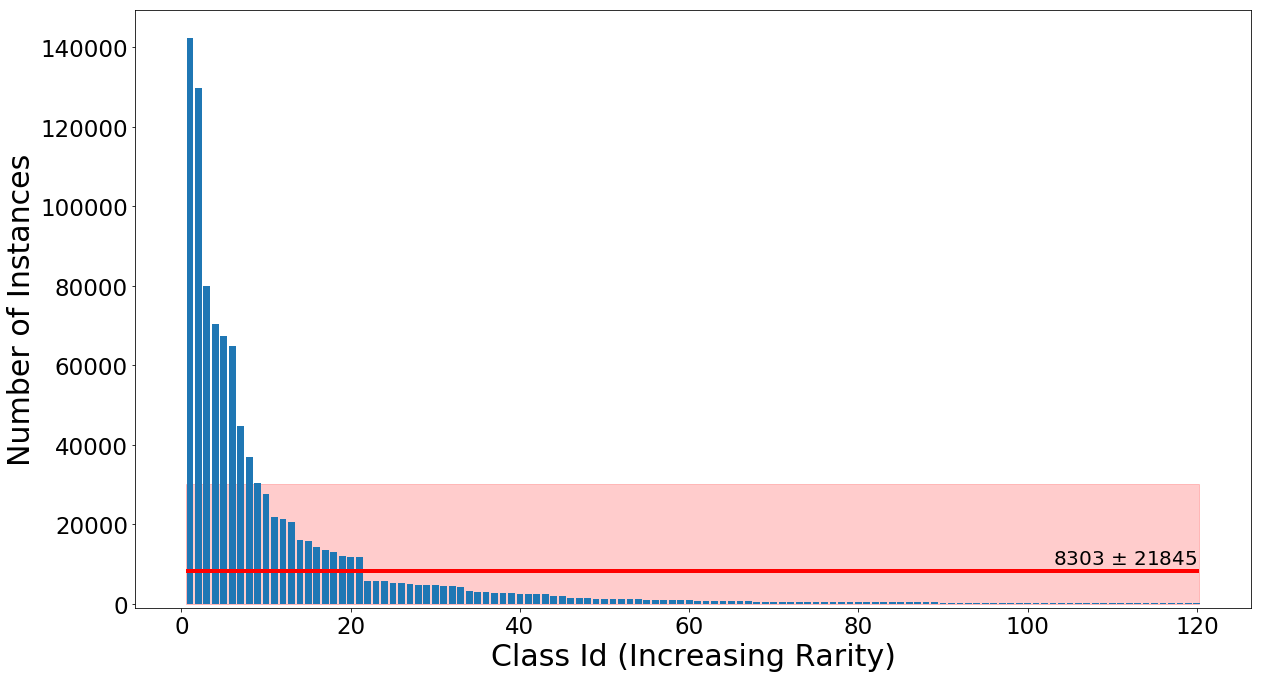

In [13]:
import matplotlib.pyplot as pltt
x = []
y = []

for c_num, (_, count) in enumerate(idx_to_class_and_len):
    x.append(c_num)
    y.append(count)

y.sort(reverse=True)
fig = pltt.figure(figsize=(20,11))
ax = fig.add_subplot(111)
pltt.bar(range(1, len(x)+1), height=y)
avg = np.mean(np.array(y))
shader_mean = np.array([avg]*120)
stdev = np.std(np.array(y))
shader_stdev = np.array([stdev]*120)
ax.annotate(r"{:.0f} $\pm$ {:.0f}".format(avg, stdev), xy=(103, 10000), fontsize=20.0)
pltt.hlines(avg, 0.5, 120.25, colors='r', linestyles='solid', label='avg', linewidth=4.0)
pltt.fill_between(np.linspace(0.5, 120.25, 120), np.maximum(0, shader_mean-shader_stdev), shader_mean+shader_stdev, color="r", alpha=0.2)

x1,x2,y1,y2 = pltt.axis()
pltt.axis((x1,x2,-1000,y2))

#set parameters for tick labels
pltt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize=23)
pltt.tick_params(axis='y', which='major', labelsize=23)
pltt.ylabel('Number of Instances', fontsize=30)
pltt.xlabel('Class Id (Increasing Rarity)', fontsize=30)


pltt.show()

In [195]:
# We create the matrices that will allows us to count the number of instances.
num_instances_check = {dataset_type: {} for dataset_type in dataset_types}

classes_in_split = {dataset_type: {setting: {fold: {} for fold in range(num_folds[dataset_type])}
                                   for setting in settings[dataset_type]}
                    for dataset_type in dataset_types}

found_global_solution = False
num_tries_global_solution = 1


while (not found_global_solution):
    try:
        clear_output(True)
        print("TEST DISJOINTNESS TYPE:", "NOT in other folds' train/val splits." if test_only_in_other_tests else "in other folds' train/val splits.")
        print()

        for dataset_type in dataset_types:
            if (dataset_type == 'DEBUG'):
                seen_classes_debug = random.sample(seen_classes_as_idx, sum(num_classes[dataset_type][split] for split in splits))
                min_count_train = min_count_train_DEBUG
                min_count_eval  = min_count_eval_DEBUG
            else:
                min_count_train = min_count_train_final_HT
                min_count_eval  = min_count_eval_final_HT
                
            found_dataset_type_solution = False
            num_tries_dataset_type_solution = 1
            max_max_num_settings_verified = 0

            while (not found_dataset_type_solution):
                try:
                    if (dataset_type == 'HT'):
                        if (HT_completely_disjoint):
                            disjoint_HT = np.zeros(len(idx_to_class_and_len), dtype=np.int64)
                        else:
                            disjoint_train_val_HT = np.zeros(len(idx_to_class_and_len), dtype=np.int64)
                            if (test_only_in_other_tests):
                                test_HT_maximums = np.zeros(len(idx_to_class_and_len), dtype=np.int64)
                    maximum_number_of_settings_verified = 0
    
                    for setting_num, setting in enumerate(settings[dataset_type]):
#                         print("SETTING AT FOR LEVEL:", setting)
                        found_setting_solution = False
                        num_tries_setting_solution = 1
                        num_seen_classes_fails = 0
                        num_unseen_classes_fails = 0
                        max_verified_classes_so_far = 0

                        while (not found_setting_solution):
                            try:
                                if (dataset_type != 'DEBUG'):
                                    if (dataset_type == 'HT' and HT_completely_disjoint):
                                        disjoint_HT_setting = np.zeros(len(idx_to_class_and_len), dtype=np.int64)
                                    else:
                                        disjoint_train_setting = np.zeros(len(idx_to_class_and_len), dtype=np.int64)
                                        disjoint_val_setting   = np.zeros(len(idx_to_class_and_len), dtype=np.int64)
                                        if (test_only_in_other_tests):
                                            test_setting_maximums = np.zeros(len(idx_to_class_and_len), dtype=np.int64)

                                num_instances_check[dataset_type][setting] = np.zeros((num_folds[dataset_type], 3, len(idx_to_class_and_len)), dtype=np.int64)

                                # Start by sampling the classes that will be present in this fold.
                                if (dataset_type != 'DEBUG'):
                                    train_samples = np.zeros(num_seen_classes, dtype=np.int64)
                                    if (dataset_type == 'HT'):
                                        val_samples   = np.zeros(num_seen_classes, dtype=np.int64)
                                        test_samples  = np.zeros(num_seen_classes, dtype=np.int64)
                                    else:
                                        val_samples   = np.zeros(len(classes_as_idx) - num_seen_classes, dtype=np.int64)
                                        test_samples  = np.zeros(len(classes_as_idx) - num_seen_classes, dtype=np.int64)

                                for fold in range(num_folds[dataset_type]):
                                    if (setting == 'N'):
                                        for split in splits:
                                            if (dataset_type == 'DEBUG'):
                                                classes_in_split[dataset_type][setting][fold][split] = list(seen_classes_debug)
                                            elif (dataset_type == 'HT'):
                                                classes_in_split[dataset_type][setting][fold][split] = list(seen_classes_as_idx)
                                            else:
                                                classes_in_split[dataset_type][setting][fold][split] = list(classes_as_idx)
                                    else:
                                        if (dataset_type == 'DEBUG'):
                                            sampled_classes = random.sample(seen_classes_debug, sum(num_classes[dataset_type][split] for split in splits))

                                            train_classes = sampled_classes[:num_classes[dataset_type]['train']]
                                            val_classes   = sampled_classes[num_classes[dataset_type]['train']:num_classes[dataset_type]['train']+num_classes[dataset_type]['val']]
                                            test_classes  = sampled_classes[-num_classes[dataset_type]['test']:]
                                            
                                        elif (dataset_type == 'HT'):
                                            train_sampled_classes = np.random.choice(np.array(seen_classes_as_idx), size=num_classes[dataset_type]['train'],
                                                                                     replace=False, p=softmax(train_samples))
                                            train_samples[train_sampled_classes] -= 50
                                            train_classes = list(train_sampled_classes)

                                            val_probs = softmax(np.array([val_sample for i, val_sample in enumerate(val_samples) if i not in train_sampled_classes]))
                                            val_sampled_classes = np.random.choice(np.array([idx for idx in seen_classes_as_idx if idx not in train_sampled_classes]),
                                                                                   size=num_classes[dataset_type]['val'], replace=False, p=val_probs)
                                            val_samples[val_sampled_classes] -= 50
                                            val_classes = list(val_sampled_classes)

                                            test_probs = softmax(np.array([test_sample for i, test_sample in enumerate(test_samples) if i not in train_sampled_classes and
                                                                                                                                        i not in val_sampled_classes]))
                                            test_sampled_classes = np.random.choice(np.array([idx for idx in seen_classes_as_idx if idx not in train_sampled_classes and
                                                                                                                                    idx not in val_sampled_classes]),
                                                                                    size=num_classes[dataset_type]['test'], replace=False, p=test_probs)
                                            test_samples[test_sampled_classes] -= 50
                                            test_classes = list(test_sampled_classes)

                                        else:
                                            samples = np.random.choice(np.array(seen_classes_as_idx), size=num_classes[dataset_type]['train'],
                                                                       replace=False, p=softmax(train_samples))
                                            train_samples[samples] -= 25
                                            train_classes = list(samples)

                                            # We bias FS-10 class sampling slightly, while still ensuring the imposed constraints, just so
                                            # it is feasible to easily sample a data distribution for the splits.
                                            if (setting == 'FS-10'):
                                                val_probs = val_samples + 8*fold*unseen_classes_probs
                                                val_probs = softmax(val_probs)
                                            else:
                                                val_probs = softmax(val_samples)
                                            samples = np.random.choice(np.array(unseen_classes_as_idx)-num_seen_classes, size=num_classes[dataset_type]['val'],
                                                                       replace=False, p=val_probs)
                                            val_samples[samples] -= 20
                                            val_classes = list(samples + num_seen_classes)

                                            # We bias FS-10 class sampling slightly, while still ensuring the imposed constraints, just so
                                            # it is feasible to easily sample a data distribution for the splits.
                                            if (setting == 'FS-10'):
                                                test_probs = np.array([test_sample for i, test_sample in enumerate(test_samples + 8*fold*unseen_classes_probs) if i not in samples])
                                                test_probs = softmax(test_probs)
                                            else:
                                                test_probs = softmax(np.array([test_sample for i, test_sample in enumerate(test_samples) if i not in samples]))
                                            samples = np.random.choice(np.array([idx for idx in unseen_classes_as_idx if idx not in (samples + num_seen_classes)])-num_seen_classes,
                                                                       size=num_classes[dataset_type]['test'],
                                                                       replace=False,
                                                                       p=test_probs)
                                            test_samples[samples] -= 20
                                            test_classes = list(samples + num_seen_classes)

                                        classes_in_split[dataset_type][setting][fold]['train'] = train_classes
                                        classes_in_split[dataset_type][setting][fold]['val']   = val_classes
                                        classes_in_split[dataset_type][setting][fold]['test']  = test_classes


                                # Check that the class distribution for this fold is approximately uniform.
                                if (dataset_type == 'HT' and setting != 'N'):
                                    classes_train_uniform_check = np.zeros(num_seen_classes, dtype=np.int8)
                                    classes_val_uniform_check   = np.zeros(num_seen_classes, dtype=np.int8)
                                    classes_test_uniform_check  = np.zeros(num_seen_classes, dtype=np.int8)

                                    for fold in range(num_folds[dataset_type]):
                                        classes_train_uniform_check[classes_in_split[dataset_type][setting][fold]['train']] += 1
                                        classes_val_uniform_check[classes_in_split[dataset_type][setting][fold]['val']] += 1
                                        classes_test_uniform_check[classes_in_split[dataset_type][setting][fold]['test']] += 1
#                                     print('\n\n')
#                                     print('TRAIN:', classes_train_uniform_check)
#                                     print('VAL:', classes_val_uniform_check)
#                                     print('TEST:', classes_test_uniform_check)

                                    train_diff = np.max(classes_train_uniform_check) - np.min(classes_train_uniform_check)
                                    err_msg = setting + " does not have an approximate uniform class distribution. Train Diff: " + str(train_diff)
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert train_diff <= uniform_class_max_diff, err_msg
                                    err_msg = setting + " does not have at least 2 times each class for train: "
                                    err_msg += str(num_seen_classes - np.sum(classes_train_uniform_check >= class_min_num_times_in_setting_split_HT))
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert (classes_train_uniform_check >= class_min_num_times_in_setting_split_HT).all(), err_msg
        
                                    val_diff = np.max(classes_val_uniform_check) - np.min(classes_val_uniform_check)
                                    err_msg = setting + " does not have an approximate uniform class distribution. Val Diff: " + str(val_diff)
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert val_diff <= uniform_class_max_diff_HT, err_msg
        
                                    test_diff = np.max(classes_test_uniform_check) - np.min(classes_test_uniform_check)
                                    err_msg = setting + " does not have an approximate uniform class distribution. Test Diff: " + str(test_diff)
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert test_diff <= uniform_class_max_diff_HT, err_msg

                                    assert (classes_val_uniform_check + classes_test_uniform_check > 0).all() 

                                # Do the same in case this is the final_evaluation dataset.
                                if (dataset_type == 'final' and setting != 'N'):
                                    classes_train_uniform_check = np.zeros(num_seen_classes, dtype=np.int8)
                                    classes_val_uniform_check   = np.zeros(len(idx_to_class_and_len), dtype=np.int8)
                                    classes_test_uniform_check  = np.zeros(len(idx_to_class_and_len), dtype=np.int8)

                                    for fold in range(num_folds[dataset_type]):
                                        classes_train_uniform_check[classes_in_split[dataset_type][setting][fold]['train']] += 1
                                        classes_val_uniform_check[classes_in_split[dataset_type][setting][fold]['val']] += 1
                                        classes_test_uniform_check[classes_in_split[dataset_type][setting][fold]['test']] += 1

                                    train_diff = np.max(classes_train_uniform_check) - np.min(classes_train_uniform_check)
                                    err_msg = setting + " does not have an approximate uniform class distribution. Train Diff: " + str(train_diff)
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert train_diff <= uniform_class_max_diff, err_msg
                                    err_msg = setting + " does not have at least 2 times each class for train: "
                                    err_msg += str(num_seen_classes - np.sum(classes_train_uniform_check[:num_seen_classes] >= 2))
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert (classes_train_uniform_check[:num_seen_classes] >= class_min_num_times_in_setting_split).all(), err_msg
        
                                    val_diff = np.max(classes_val_uniform_check[num_seen_classes:]) - np.min(classes_val_uniform_check[num_seen_classes:])
                                    err_msg = setting + " does not have an approximate uniform class distribution. Val Diff: " + str(val_diff)
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert val_diff <= uniform_class_max_diff, err_msg
                                    err_msg = setting + " does not have at least 2 times each class for val: "
                                    err_msg += str((len(idx_to_class_and_len) - num_seen_classes) - np.sum(classes_val_uniform_check[num_seen_classes:] >= 2))
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert (classes_val_uniform_check[num_seen_classes:] >= class_min_num_times_in_setting_split).all(), err_msg
        
                                    test_diff = np.max(classes_test_uniform_check[num_seen_classes:]) - np.min(classes_test_uniform_check[num_seen_classes:])
                                    err_msg = setting + " does not have an approximate uniform class distribution. Test Diff: " + str(test_diff)
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert test_diff <= uniform_class_max_diff, err_msg
                                    err_msg = setting + " does not have at least 2 times each class for test: "
                                    err_msg += str((len(idx_to_class_and_len) - num_seen_classes) - np.sum(classes_test_uniform_check[num_seen_classes:] >= 2))
                                    err_msg += " | (max: " + str(max_verified_classes_so_far) + ")"
                                    assert (classes_test_uniform_check[num_seen_classes:] >= class_min_num_times_in_setting_split).all(), err_msg
                                

                                # Now we sample the number of instances for this fold.
                                for fold in range(num_folds[dataset_type]):
#                                     print(setting)
                                    if (setting == 'N' or setting == 'ZS'):
                                        for split in splits:
                                            if (split != 'train'):
                                                min_count = min_count_eval
                                            else:
                                                min_count = 1 if setting == 'N' else min_count_train
                                            samples = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold][split]],
                                                                                              split_size[dataset_type][split], min_count=min_count)
                                            num_instances_check[dataset_type][setting][fold, splits[split], classes_in_split[dataset_type][setting][fold][split]] = samples
#                                             if (dataset_type == 'HT'):
#                                                 print('\n\n\n', dataset_type, setting, fold, split, '\n', num_instances_check[dataset_type][setting].shape,
#                                                       '\n', num_instances_check[dataset_type][setting][fold, splits[split], :])

                                    elif (setting == 'GZS'):
                                        for split in splits:
                                            min_count = min_count_train if split == 'train' else min_count_eval
                                            if (split == 'train'):
                                                samples = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold][split]],
                                                                                                  split_size[dataset_type][split], min_count=min_count)
                                                num_instances_check[dataset_type][setting][fold, splits[split], classes_in_split[dataset_type][setting][fold][split]] = samples
                                            else:
                                                t_samples = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold]['train']],
                                                                                                    int(0.5*split_size[dataset_type][split]), min_count=min_count_eval)
                                                e_samples = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold][split]],
                                                                                                    split_size[dataset_type][split] - int(0.5*split_size[dataset_type][split]),
                                                                                                    min_count=min_count_eval)
                                                num_instances_check[dataset_type][setting][fold, splits[split], classes_in_split[dataset_type][setting][fold]['train']] = t_samples
                                                num_instances_check[dataset_type][setting][fold, splits[split], classes_in_split[dataset_type][setting][fold][split]]   = e_samples

                                    else: # (Generalised) Few-Shot Setting.
                                        num_shots = int(setting.split('-')[1])
                                        t_samples_from_val = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold]['val']],
                                                                                                     num_shots*len(classes_in_split[dataset_type][setting][fold]['val']),
                                                                                                     min_count=num_shots)
                                        t_samples_from_tst = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold]['test']],
                                                                                                     num_shots*len(classes_in_split[dataset_type][setting][fold]['test']),
                                                                                                     min_count=num_shots)
                                        eval_num_samples = np.sum(t_samples_from_val) + np.sum(t_samples_from_tst)
                                        t_samples_from_trn = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold]['train']],
                                                                                                     split_size[dataset_type]['train'] - eval_num_samples,
                                                                                                     min_count=min_count_train)
                                        num_instances_check[dataset_type][setting][fold, splits['train'], classes_in_split[dataset_type][setting][fold]['train']] = t_samples_from_trn
                                        num_instances_check[dataset_type][setting][fold, splits['train'], classes_in_split[dataset_type][setting][fold]['val']]   = t_samples_from_val
                                        num_instances_check[dataset_type][setting][fold, splits['train'], classes_in_split[dataset_type][setting][fold]['test']]  = t_samples_from_tst

                                        for split in splits:
                                            if (split == 'train'):
                                                continue
                                            else:
                                                if (setting[0] == 'F'): # Non-Generalised Setting
                                                    samples = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold][split]],
                                                                                                      split_size[dataset_type][split], min_count=min_count_eval)
                                                    num_instances_check[dataset_type][setting][fold, splits[split], classes_in_split[dataset_type][setting][fold][split]] = samples

                                                else: # Generalised Setting
                                                    t_samples = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold]['train']],
                                                                                                        int(0.5*split_size[dataset_type][split]), min_count=min_count_eval)
                                                    e_samples = get_num_samples_and_guarantee_min_count(classes_num_insts[classes_in_split[dataset_type][setting][fold][split]],
                                                                                                        split_size[dataset_type][split] - int(0.5*split_size[dataset_type][split]),
                                                                                                        min_count=min_count_eval)
                                                    num_instances_check[dataset_type][setting][fold, splits[split], classes_in_split[dataset_type][setting][fold]['train']] = t_samples
                                                    num_instances_check[dataset_type][setting][fold, splits[split], classes_in_split[dataset_type][setting][fold][split]]   = e_samples


                                    # Verify that it is possible to build this fold.
                                    if (dataset_type != 'DEBUG'):
                                        if (dataset_type == 'HT'):
                                            fold_num_insts = np.sum(num_instances_check[dataset_type][setting][fold], axis=0)
                                        elif (dataset_type == 'final'):
                                            if (HT_completely_disjoint):
                                                fold_train_num_insts = np.maximum(disjoint_HT, num_instances_check[dataset_type][setting][fold][splits['train']])
                                            else:
                                                fold_train_num_insts = np.maximum(disjoint_train_val_HT + test_HT_maximums, num_instances_check[dataset_type][setting][fold][splits['train']])
                                            fold_num_insts = fold_train_num_insts + np.sum(num_instances_check[dataset_type][setting][fold][1:], axis=0)

                                        verify_fold_less_equal = np.less_equal(fold_num_insts, classes_num_insts)
                                        err_msg = dataset_type + ", " + setting + ", " + str(fold) + ": " + str(np.sum(verify_fold_less_equal))
                                        if (dataset_type == 'final'):
                                            if (not all(verify_fold_less_equal[:len(seen_classes_as_idx)])):
                                                num_seen_classes_fails += 1
                                            if (not all(verify_fold_less_equal[len(seen_classes_as_idx):])):
                                                num_unseen_classes_fails += 1
                                        assert verify_fold_less_equal.all(), err_msg

                                        # Increment counts to test for setting disjointness.
                                        if (dataset_type == 'HT' and HT_completely_disjoint):
                                            disjoint_HT_setting += fold_num_insts
                                        else:
                                            disjoint_train_setting += num_instances_check[dataset_type][setting][fold][splits['train']]
                                            disjoint_val_setting   += num_instances_check[dataset_type][setting][fold][splits['val']]
                                            if (test_only_in_other_tests):
                                                test_setting_maximums = np.maximum(test_setting_maximums, num_instances_check[dataset_type][setting][fold][splits['test']])

                                # Now verify that this entire setting is possible by itself.
                                if (dataset_type != 'DEBUG'):
                                    if (test_only_in_other_tests):
                                        if (dataset_type == 'HT'):
                                            if (HT_completely_disjoint):
                                                total_setting_num_instances = disjoint_HT_setting 
                                            else:
                                                total_setting_num_instances = disjoint_train_setting + disjoint_val_setting + test_setting_maximums
                                        elif (dataset_type == 'final'):
                                            # This accounts for the train set being allowed to reuse instances from the 'HT' dataset.
                                            if (HT_completely_disjoint):
                                                setting_train_num_insts = np.maximum(disjoint_HT, disjoint_train_setting)
                                            else:
                                                setting_train_num_insts = np.maximum(disjoint_train_val_HT + test_HT_maximums, disjoint_train_setting)
                                            total_setting_num_instances = setting_train_num_insts + disjoint_val_setting + test_setting_maximums
                                    verify_setting_less_equal = np.less_equal(total_setting_num_instances, classes_num_insts)

                                    if (dataset_type == 'final'):
                                        if (not all(verify_setting_less_equal[:len(seen_classes_as_idx)])):
                                            num_seen_classes_fails += 1
                                        if (not all(verify_setting_less_equal[len(seen_classes_as_idx):])):
                                            num_unseen_classes_fails += 1

                                    num_verified_classes = np.sum(verify_setting_less_equal)
                                    if (max_verified_classes_so_far < num_verified_classes):
                                        max_verified_classes_so_far = num_verified_classes


                                    err_msg = "(" + dataset_type + ", " + setting + ") verified number of relations: " + str(np.sum(verify_setting_less_equal))
                                    err_msg += " (max: " + str(max_verified_classes_so_far) + ")"
                                    assert verify_setting_less_equal.all(), err_msg

                                found_setting_solution = True

                            except AssertionError as err:
                                if (not found_setting_solution):
                                    if (dataset_type == 'HT'):
                                        print('\x1b[2K\r', err, end="", flush=True)
                                        if (num_tries_setting_solution == 5000):
                                            raise AssertionError(err)
                                    elif (dataset_type == 'final'):
                                        if (num_tries_setting_solution >= 2000 and num_seen_classes_fails/num_tries_setting_solution > 0.2):
                                            raise AssertionError(err)
                                    if (dataset_type == 'final' and (num_tries_setting_solution - 1) % 250 == 0):
                                        print('\r' + str(err) + " | Number of attempts: " + str(num_tries_setting_solution) +
                                              " ('seen' fails: " + str(num_seen_classes_fails) +
                                              ' ({:.2f}%)'.format(100*num_seen_classes_fails/num_tries_setting_solution) + ")" +
                                              " ('unseen' fails: " + str(num_unseen_classes_fails) +
                                              ' ({:.2f}%)'.format(100*num_unseen_classes_fails/num_tries_setting_solution) + ")",
                                              end="", flush=True)
                                    num_tries_setting_solution += 1

                        # Increment counts to test for 'HT' disjointness and check for disjointness.
                        if (dataset_type == 'HT'):
                            if (HT_completely_disjoint):
                                disjoint_HT += disjoint_HT_setting
                                verify_disjoint_HT = disjoint_HT
                            else:
                                disjoint_train_val_HT += disjoint_train_setting + disjoint_val_setting
                                if (test_only_in_other_tests):
                                    test_HT_maximums = np.maximum(test_HT_maximums, test_setting_maximums)
                                verify_disjoint_HT = disjoint_train_val_HT + test_HT_maximums

                            # Here we check if it is still possible (with this new setting) to create the dataset_type 'HT'.
                            verify_HT_settings_less_equal = np.less_equal(verify_disjoint_HT, classes_num_insts)
                            err_msg = dataset_type + " (verified number of settings before failure): " + str(setting_num) + "/"
                            err_msg += str(len(settings[dataset_type])) + "." + " | " + str(maximum_number_of_settings_verified)
                            assert verify_HT_settings_less_equal.all(), err_msg

                        if (dataset_type != 'DEBUG'):
                            maximum_number_of_settings_verified += 1

                            if (max_max_num_settings_verified < maximum_number_of_settings_verified):
                                max_max_num_settings_verified = maximum_number_of_settings_verified

                            if (dataset_type == 'HT'):
                                print("\rDataset: " + dataset_type + " | Maximum Verified Settings: " +
                                      str(settings[dataset_type][:max_max_num_settings_verified]) +
                                      " (" + str(maximum_number_of_settings_verified) + ")", end="", flush=True)
                            if (dataset_type == 'final'):
                                print("\rFound solution for (" + dataset_type + ", " + setting + ") after " + str(num_tries_setting_solution) + " iterations.")

                            if (maximum_number_of_settings_verified == len(settings[dataset_type])):
                                found_dataset_type_solution = True
                        else:
                            found_dataset_type_solution = True

                except AssertionError as err:
                    if (not found_dataset_type_solution):
                        if (dataset_type == 'final'):
                            raise RuntimeError(err)
                        num_tries_dataset_type_solution += 1


            print("\nFound solution for (" + dataset_type + ") after " + str(num_tries_dataset_type_solution) + " iterations.\n")
            if (dataset_type == 'final'):
                found_global_solution = True

    except RuntimeError as err:
        if (not found_global_solution):
            clear_output()
            num_tries_global_solution += 1





with open(join_path([path_proposed_splits_original_masking, 'proposed_splits_data_distribution.dat']), 'wb') as f:
    pickle.dump(num_instances_check, f)
    pickle.dump(classes_in_split, f)


with open(join_path([path_proposed_splits_original_masking, 'proposed_splits_meta_data.txt']), 'w', encoding='utf-8') as f:
    pretty_dict_json_dump(proposed_splits_meta_data, f)

TEST DISJOINTNESS TYPE: NOT in other folds' train/val splits.


Found solution for (DEBUG) after 1 iterations.

Dataset: HT | Maximum Verified Settings: ['N', 'ZS', 'GZS', 'FS-1', 'GFS-1', 'FS-2', 'GFS-2', 'FS-5', 'GFS-5', 'FS-10', 'GFS-10'] (11)
Found solution for (HT) after 5 iterations.

Found solution for (final, N) after 1134 iterations.
Found solution for (final, ZS) after 56 iterations.
Found solution for (final, GZS) after 26 iterations.
Found solution for (final, FS-1) after 32 iterations.
Found solution for (final, GFS-1) after 93 iterations.
Found solution for (final, FS-2) after 4 iterations.
Found solution for (final, GFS-2) after 43 iterations.
Found solution for (final, FS-5) after 13 iterations.
Found solution for (final, GFS-5) after 4 iterations.
Found solution for (final, FS-10) after 8892 iterations.
Found solution for (final, GFS-10) after 42 iterations.

Found solution for (final) after 1 iterations.



In [6]:
with open(join_path([path_proposed_splits_original, 'proposed_splits_data_distribution.dat']), 'rb') as f:
    num_instances_check = pickle.load(f)
    classes_in_split = pickle.load(f)

disjoint_HT = sum(np.sum(num_instances_check['HT'][setting], axis=(0, 1)) for setting in num_instances_check['HT'])


with open(join_path([path_proposed_splits_original, 'proposed_splits_meta_data.txt']), 'r', encoding='utf-8') as f:
    proposed_splits_meta_data = pretty_dict_json_load(f)

In [7]:
np.set_printoptions(formatter={'all':lambda x: '{:5d}'.format(x)})
def specific_dataset_print(dataset_type, setting, fold, split, mask_train, mask_class_dist):
    # The interact module automatically retrieves the dictionary values, for the corresponding keys.

    print("\n"*5)
    if (setting != 'N'):
        train_mask = (num_instances_check[dataset_type][setting][fold][0] == 0).astype(np.int8)
        if (setting[:3] == 'GFS' or setting[:3] == 'FS-'):
            train_mask += (num_instances_check[dataset_type][setting][fold][0] == int(setting.split('-')[1])).astype(np.int8)
    else:
        train_mask = np.ones_like(num_instances_check[dataset_type][setting][fold][0], dtype=np.int8)

    if (setting[:3] == 'GFS' or setting[:3] == 'FS-'):
        anti_train_mask = (~train_mask.astype(np.bool)).astype(np.int8)
    else:
        anti_train_mask = np.ones_like(num_instances_check[dataset_type][setting][fold][0], dtype=np.int8)
        

    masked = np.multiply(train_mask, num_instances_check[dataset_type][setting][fold][split])
    anti_masked = np.multiply(anti_train_mask, num_instances_check[dataset_type][setting][fold][split])

    
    print('Fold num insts:', sum(np.sum(num_instances_check[dataset_type][setting][fold][split_num])
                                 for split_num in proposed_splits_meta_data['splits'].values()))
    print('Split num insts:', np.sum(num_instances_check[dataset_type][setting][fold][split]))
    print("'Exclusive' split num insts:", np.sum(masked if split != 0 else anti_masked))

    if (setting != 'N' and not mask_class_dist):
        print("'seen' classes distribution train:")
        if (dataset_type == 'HT' or dataset_type == 'DEBUG'):
            train = np.zeros(proposed_splits_meta_data['num_seen_classes'], dtype=np.int8)
            val = np.zeros(proposed_splits_meta_data['num_seen_classes'], dtype=np.int8)
            test = np.zeros(proposed_splits_meta_data['num_seen_classes'], dtype=np.int8)
        else:
            total_num_classes = num_instances_check[dataset_type][setting][fold][split].shape[0]
            train = np.zeros(proposed_splits_meta_data['num_seen_classes'], dtype=np.int8)
            val = np.zeros(total_num_classes - proposed_splits_meta_data['num_seen_classes'], dtype=np.int8)
            test = np.zeros(total_num_classes - proposed_splits_meta_data['num_seen_classes'], dtype=np.int8)

        for fold_num in range(proposed_splits_meta_data['num_folds'][dataset_type]):
            train[classes_in_split[dataset_type][setting][fold_num]['train']] += 1
            val_classes = [class_idx - (proposed_splits_meta_data['num_seen_classes'] if dataset_type == 'final' else 0)
                           for class_idx in classes_in_split[dataset_type][setting][fold_num]['val']]
            val[val_classes] += 1
            test_classes = [class_idx - (proposed_splits_meta_data['num_seen_classes'] if dataset_type == 'final' else 0)
                            for class_idx in classes_in_split[dataset_type][setting][fold_num]['test']]
            test[test_classes] += 1

    #     dist_seen = np.sum(num_instances_check[dataset_type][setting][fold_num][0][:end] != 0
    #                        for fold_num in range(proposed_splits_meta_data['num_folds'][dataset_type]))
        print("Diff max-min:", np.max(train) - np.min(train))
        print(train)
        print("'unseen' classes distribution val:")
    #     dist_unseen_val = np.sum(num_instances_check[dataset_type][setting][fold_num][1][start:-end_eval] != 0
    #                              for fold_num in range(proposed_splits_meta_data['num_folds'][dataset_type]))
        print("Diff max-min:", np.max(val) - np.min(val))
        print(val)
        print("'unseen' classes distribution test:")
    #     dist_unseen_test = np.sum(num_instances_check[dataset_type][setting][fold_num][2][start:-end_eval] != 0
    #                               for fold_num in range(proposed_splits_meta_data['num_folds'][dataset_type]))
        print("Diff max-min:", np.max(test) - np.min(test))
        print(test)
        print()
    print(masked if mask_train else num_instances_check[dataset_type][setting][fold][split])

def select_dataset_type_print(dataset_type):
    global settings
    global num_folds
    global splits
    interact(specific_dataset_print, dataset_type=fixed(dataset_type), setting=list(num_instances_check[dataset_type].keys()),
             fold=list(range(proposed_splits_meta_data['num_folds'][dataset_type])), split=proposed_splits_meta_data['splits'],
             mask_train=False, mask_class_dist=False)

interact(select_dataset_type_print, dataset_type=proposed_splits_meta_data['dataset_types']);

interactive(children=(Dropdown(description='dataset_type', options=('DEBUG', 'HT', 'final'), value='DEBUG'), O…

# New - getting instances into files, already separating into different masking types

#### We use this specific one below to get instances into files when we are already accouting for instance uniqueness with masking when creating the splits distribution.

In [204]:
# We define the fold names of each dataset_type.
dataset_type_names = {'HT': 'hyperparameter_tuning', 'final': 'final_evaluation', 'DEBUG': 'DEBUG'}
masking_types = ['original', 'unmasked', 'sub_obj_masking', 'NER_masking']

# We get the path to the data files separated by class.
max_sentence_length = proposed_splits_meta_data['max_sentence_length']
max_sentence_length_exclusive_unique_masking = 'max_tokenized_sentence_len_' + str(max_sentence_length) + '_exclusive_and_unique_relation_masking'
path_dir_capped_exclusive_unique_masking = join_path([path_ours, 'Levy_by_relation', max_sentence_length_exclusive_unique_masking])


# We open the destination files, start keeping track of labels and relations exclusive to each split.
paths = {}
labels = {}
relations_exclusive_to_split = {}
for masking_type in masking_types:
    paths[masking_type] = {}
    labels[masking_type] = {}
    relations_exclusive_to_split[masking_type] = {}

    path = join_path([path_proposed_splits_masking, masking_type]) + os.sep
    directory = os.path.dirname(path)
    if (not os.path.exists(directory)):
        os.makedirs(directory)

    for dataset_type in proposed_splits_meta_data['dataset_types']:
        paths[masking_type][dataset_type] = {}
        labels[masking_type][dataset_type] = {}
        relations_exclusive_to_split[masking_type][dataset_type] = {}

        path = join_path([path_proposed_splits_masking, masking_type,
                          dataset_type_names[dataset_type]]) + os.sep
        directory = os.path.dirname(path)
        if (not os.path.exists(directory)):
            os.makedirs(directory)

        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            paths[masking_type][dataset_type][setting] = {}
            labels[masking_type][dataset_type][setting] = {}
            relations_exclusive_to_split[masking_type][dataset_type][setting] = {}

            path = join_path([path_proposed_splits_masking, masking_type,
                              dataset_type_names[dataset_type], setting]) + os.sep
            directory = os.path.dirname(path)
            if (not os.path.exists(directory)):
                os.makedirs(directory)

            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                paths[masking_type][dataset_type][setting][fold] = {}
                labels[masking_type][dataset_type][setting][fold] = {}
                relations_exclusive_to_split[masking_type][dataset_type][setting][fold] = {}

                path = join_path([path_proposed_splits_masking, masking_type,
                                  dataset_type_names[dataset_type], setting, str(fold)]) + os.sep

                directory = os.path.dirname(path)
                if (not os.path.exists(directory)):
                    os.makedirs(directory)

                for split in proposed_splits_meta_data['splits']:
                    path = join_path([path_proposed_splits_masking, masking_type,
                                  dataset_type_names[dataset_type], setting, str(fold), split + ".txt"])
                    paths[masking_type][dataset_type][setting][fold][split] = open(path, 'w', encoding='utf-8')
                    labels[masking_type][dataset_type][setting][fold][split] = []
                    relations_exclusive_to_split[masking_type][dataset_type][setting][fold][split] = []

# We get the total number of instances to be processed. Mostly for printing purposes and estimating remaining time.
num_instances_per_relation = {}
for relation in relation_list:
    num_instances_per_relation[relation] = file_len(join_path([path_dir_capped_exclusive_unique_masking, 'original',
                                                               re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']))
total_num_instances = sum(num_instances_per_relation[relation] for relation in num_instances_per_relation)


# We start the process of creating the splits.
instance_num = 0
try:
    for r_num, relation in enumerate(relation_list):
        print('\x1b[2K\r' + str(r_num + 1) + '/' + str(len(relation_list)) + '   ' + relation, end="", flush=True)
        for dataset_type in proposed_splits_meta_data['dataset_types']:
            for setting in proposed_splits_meta_data['settings'][dataset_type]:
                for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                    for split in proposed_splits_meta_data['splits']:
                        for masking_type in masking_types:
                            n = num_instances_check[dataset_type][setting][fold][proposed_splits_meta_data['splits'][split]][proposed_splits_meta_data['class_to_idx'][relation]]
                            labels[masking_type][dataset_type][setting][fold][split] += [relation] * n
                            if (proposed_splits_meta_data['class_to_idx'][relation] in classes_in_split[dataset_type][setting][fold][split]):
                                relations_exclusive_to_split[masking_type][dataset_type][setting][fold][split].append(relation)

        data_to_write = {masking_type: [] for masking_type in masking_types}

        # Load all the data pertaining this relation.
        for masking_type in masking_types:
            if (masking_type != 'unmasked'):
                path_relation = join_path([path_dir_capped_exclusive_unique_masking, masking_type, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt'])
                with open(path_relation, 'r', encoding='utf-8') as f:
                    for line in f:
                        line_temp = line.strip()
                        if (masking_type == 'original'):
                            data_to_write['original'].append(relation + '\t' + line_temp)
                            data_to_write['unmasked'].append(''.join(space_word_tokenize_string(line_temp.split('\t')[0], tokenizer)))
                        else:
                            data_to_write[masking_type].append(line_temp)
                            


        err_msg = "The number of instances is different from what was expected."
        n = proposed_splits_meta_data['idx_to_class_and_len'][proposed_splits_meta_data['class_to_idx'][relation]][1]
        assert all(len(data_to_write[masking_type]) == n for masking_type in masking_types), err_msg

        # Shuffle data
        zipped_data_to_write = list(zip(*tuple(data_to_write[masking_type] for masking_type in masking_types)))
        random.shuffle(zipped_data_to_write)
        for masking_type, masking_type_train_data in list(zip(data_to_write.keys(), list(zip(*zipped_data_to_write)))):
            data_to_write[masking_type] = masking_type_train_data


        num_instances_disjoint_HT = disjoint_HT[proposed_splits_meta_data['class_to_idx'][relation]]
        HT_instances = {masking_type: data_to_write[masking_type][:num_instances_disjoint_HT] for masking_type in data_to_write}
        non_HT_instances = {masking_type: data_to_write[masking_type][num_instances_disjoint_HT:] for masking_type in data_to_write}

        # We start by writing out the 'DEBUG' and 'HT' datasets.
        for masking_type in masking_types:
            for dataset_type in proposed_splits_meta_data['dataset_types']:
                if (dataset_type != 'final'):
                    current_slice_start = 0
                    for setting in proposed_splits_meta_data['settings'][dataset_type]:
                        for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                            for split in proposed_splits_meta_data['splits']:
                                current_slice_end = current_slice_start
                                current_slice_end += num_instances_check[dataset_type][setting][fold][proposed_splits_meta_data['splits'][split]][proposed_splits_meta_data['class_to_idx'][relation]]
                                # DEBUG classes also belong to the seen classes.
                                for line in HT_instances[masking_type][current_slice_start:current_slice_end]:
                                    paths[masking_type][dataset_type][setting][fold][split].write(line + '\n')
                                current_slice_start += num_instances_check[dataset_type][setting][fold][proposed_splits_meta_data['splits'][split]][proposed_splits_meta_data['class_to_idx'][relation]]

        # Here we take care of the 'final' dataset
        fully_disjoint_from_HT_settings = {}
        disjoint_test_splits_but_no_disjointness_from_HT_settings = {}
        test_in_other_tests_settings = {}
        for setting in proposed_splits_meta_data['settings']['final']:
            if (setting not in fully_disjoint_from_HT_settings):
                fully_disjoint_from_HT_settings[setting] = []
                disjoint_test_splits_but_no_disjointness_from_HT_settings[setting] = []
                test_in_other_tests_settings[setting] = []

            fold_sums = np.sum(num_instances_check['final'][setting], axis=0)
            num_instances_disjoint_train = fold_sums[0][proposed_splits_meta_data['class_to_idx'][relation]]
            num_instances_disjoint_val = fold_sums[1][proposed_splits_meta_data['class_to_idx'][relation]]
            num_instances_disjoint_test = fold_sums[2][proposed_splits_meta_data['class_to_idx'][relation]]
            num_max_instances_test = np.max(num_instances_check['final'][setting], axis=0)[2][proposed_splits_meta_data['class_to_idx'][relation]]

            train_final_bigger_disjoint_HT = num_instances_disjoint_train > num_instances_disjoint_HT

            fully_disjoint = num_instances_disjoint_train + num_instances_disjoint_val + num_instances_disjoint_test < len(non_HT_instances['original'])
            train_in_non_HT_instances = num_instances_disjoint_train - num_instances_disjoint_HT if train_final_bigger_disjoint_HT else 0
            disjoint_test = train_in_non_HT_instances + num_instances_disjoint_val + num_instances_disjoint_test < len(non_HT_instances['original'])

            final_train_instances = {}
            final_val_instances = {}
            final_test_instances = {}

            if (fully_disjoint):
                fully_disjoint_from_HT_settings[setting].append(relation)
                for masking_type in masking_types:
                    final_train_instances[masking_type] = non_HT_instances[masking_type][:num_instances_disjoint_train]
                    final_val_instances[masking_type] = non_HT_instances[masking_type][num_instances_disjoint_train:num_instances_disjoint_train + num_instances_disjoint_val]
                    final_test_instances[masking_type] = non_HT_instances[masking_type][-num_instances_disjoint_test:]
            else:
                if (disjoint_test):
                    disjoint_test_splits_but_no_disjointness_from_HT_settings[setting].append(relation)
                else:
                    test_in_other_tests_settings[setting].append(relation)

                for masking_type in masking_types:
                    if (disjoint_test):
                        final_train_instances[masking_type] = HT_instances[masking_type] + non_HT_instances[masking_type][:-(num_instances_disjoint_test + num_instances_disjoint_val)]
                        final_val_instances[masking_type] = non_HT_instances[masking_type][-(num_instances_disjoint_test + num_instances_disjoint_val):-num_instances_disjoint_test]
                        final_test_instances[masking_type] = non_HT_instances[masking_type][-num_instances_disjoint_test:]
                    else:
                        # This way we can have a bigger pool of possible samples for the test splits.
                        final_train_instances[masking_type] = HT_instances[masking_type] + non_HT_instances[masking_type][:train_in_non_HT_instances]
                        final_val_instances[masking_type] = non_HT_instances[masking_type][train_in_non_HT_instances:train_in_non_HT_instances + num_instances_disjoint_val]
                        assert len(non_HT_instances[masking_type]) - train_in_non_HT_instances + num_instances_disjoint_val >= num_max_instances_test, 'TEST IN TEST ERROR'
                        final_test_instances[masking_type] = non_HT_instances[masking_type][train_in_non_HT_instances + num_instances_disjoint_val:]

                # We shuffle the training instances to mix HT instances with potential non-HT instances.
                zipped_train = list(zip(*tuple(final_train_instances[masking_type] for masking_type in masking_types)))
                random.shuffle(zipped_train)
                for masking_type, masking_type_train_data in list(zip(final_train_instances.keys(), list(zip(*zipped_train)))):
                    final_train_instances[masking_type] = masking_type_train_data

            # Now we write out the this specific setting of the 'final' dataset.
            current_slice_start = {'train': 0, 'val': 0, 'test': 0}
            for fold in range(proposed_splits_meta_data['num_folds']['final']):
                for split in proposed_splits_meta_data['splits']:
                    current_slice_end = current_slice_start[split]
                    current_slice_end += num_instances_check['final'][setting][fold][proposed_splits_meta_data['splits'][split]][proposed_splits_meta_data['class_to_idx'][relation]]
                    current_data = {}
                    if (split == 'train'):
                        for masking_type in masking_types:
                            current_data[masking_type] = final_train_instances[masking_type]
                    elif (split == 'val'):
                        for masking_type in masking_types:
                            current_data[masking_type] = final_val_instances[masking_type]
                    else:
                        if (fully_disjoint or disjoint_test):
                            for masking_type in masking_types:
                                current_data[masking_type] = final_test_instances[masking_type]
                        else:
                            zipped_test = list(zip(*tuple(final_test_instances[masking_type]
                                                          for masking_type in masking_types)))
                            random.shuffle(zipped_test)
                            for masking_type, masking_type_test_data in list(zip(final_test_instances.keys(), list(zip(*zipped_test)))):
                                final_test_instances[masking_type] = masking_type_test_data
                            for masking_type in masking_types:
                                current_data[masking_type] = final_test_instances[masking_type]

                    for masking_type in masking_types:
                        for line in current_data[masking_type][current_slice_start[split]:current_slice_end]:
                            paths[masking_type]['final'][setting][fold][split].write(line + '\n')

                    if (split == 'test' and not fully_disjoint and not disjoint_test):
                        pass
                    else:
                        current_slice_start[split] += num_instances_check['final'][setting][fold][proposed_splits_meta_data['splits'][split]][proposed_splits_meta_data['class_to_idx'][relation]]

except:
    # Close file_pointers in case of error.
    for masking_type in masking_types:
        for dataset_type in proposed_splits_meta_data['dataset_types']:
            for setting in proposed_splits_meta_data['settings'][dataset_type]:
                for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                    for split in proposed_splits_meta_data['splits']:
                        paths[masking_type][dataset_type][setting][fold][split].close()
    raise

print('\n\n\nThe following settings are fully disjoint (also disjoint from the HT dataset):')
for setting in fully_disjoint_from_HT_settings:
    if (all(relation in fully_disjoint_from_HT_settings[setting] for relation in relation_list)):
        print(setting)

print(
    '\n\nThe following settings have disjoint test splits (However, some of the train instances will also exist in the HT dataset):')
for setting in disjoint_test_splits_but_no_disjointness_from_HT_settings:
    if (all(relation in fully_disjoint_from_HT_settings[setting] or relation in
            disjoint_test_splits_but_no_disjointness_from_HT_settings[setting] for relation in relation_list) and
            any(relation not in fully_disjoint_from_HT_settings[setting] for relation in relation_list)):
        print(setting)

print(
    '\n\nThe following settings do NOT have disjoint test splits (and some of the train instances will also exist in the HT dataset):')
for setting in test_in_other_tests_settings:
    if (any(relation not in fully_disjoint_from_HT_settings[setting] and relation not in
            disjoint_test_splits_but_no_disjointness_from_HT_settings[setting] for relation in relation_list)):
        print(setting)

# Close file_pointers.
for masking_type in masking_types:
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                for split in proposed_splits_meta_data['splits']:
                    split_cls = relations_exclusive_to_split[masking_type][dataset_type][setting][fold][split]
                    with open(paths[masking_type][dataset_type][setting][fold][split].name[:-4] + '_relations.txt', 'w', encoding='utf-8') as f:
                        for relation in split_cls:
                            f.write(relation + '\n')
                    if (masking_type != 'original'):
                        with open(paths[masking_type][dataset_type][setting][fold][split].name[:-4] + '.lbs', 'wb') as f:
                            pickle.dump(labels[masking_type][dataset_type][setting][fold][split], f)
                    paths[masking_type][dataset_type][setting][fold][split].close()

120/120   voice type


The following settings are fully disjoint (also disjoint from the HT dataset):


The following settings have disjoint test splits (However, some of the train instances will also exist in the HT dataset):


The following settings do NOT have disjoint test splits (and some of the train instances will also exist in the HT dataset):
N
ZS
GZS
FS-1
GFS-1
FS-2
GFS-2
FS-5
GFS-5
FS-10
GFS-10


### Now that we have found a data distribution (for each dataset_type, setting and fold) that respects the imposed constraints, we actually get the instances into each separate file. Wecreate different experiment settings, concerning the masking of entities in the sentences. Specifically, one where we simply use the plain sentences (disregarding any information concerning the entities involved in the relation we are attempting to produce), one where we mask out the entities of interest, namely with SUBJECT_ENTITY and OBJECT_ENTITY (since we assume we have binary relations) and a last one where we simply mask all entities recognized by a NER algorithm (where we hope it behaves the same as the unmasked one, but without allowing the model to overfit on specific entities).

In [6]:
# We run this part on gpu or otherwise it would take forever.
# create_splits_for_masking_types(masking_types=['original', 'unmasked', 'sub_obj_masking', 'NER_masking'])

#### As a sanity check we verify that the disjointness guarantees are actually verified. We also check that the classes present in each split are the correct ones and also check the minimum number of instances per split is correct.

In [205]:
dataset_types = proposed_splits_meta_data['dataset_types']
dataset_type_names = {'HT': 'hyperparameter_tuning', 'final': 'final_evaluation', 'DEBUG': 'DEBUG'}
masking_types = ['original', 'unmasked', 'sub_obj_masking', 'NER_masking']

HT = {}

paths  = {}
labels = {}
for masking_type in masking_types:
    paths[masking_type] = {}
    labels[masking_type] = {}
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        paths[masking_type][dataset_type] = {}
        labels[masking_type][dataset_type] = {}
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            paths[masking_type][dataset_type][setting] = {}
            labels[masking_type][dataset_type][setting] = {}
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                paths[masking_type][dataset_type][setting][fold] = {}
                labels[masking_type][dataset_type][setting][fold] = {}
                for split in proposed_splits_meta_data['splits']:
                    path = join_path([path_proposed_splits_masking, masking_type, dataset_type_names[dataset_type], setting, str(fold), split])
                    paths[masking_type][dataset_type][setting][fold][split] = path
                    labels[masking_type][dataset_type][setting][fold][split] = []


                    
# We start by verifying that all labels are correctly assigned (for the different masking types) and that the correct classes are in each split.
# We start by the classes in each split (which we test only on the original. Since we compara each masking type's labels with the original, by
# association we are also testing for the correct classes).
for dataset_type in proposed_splits_meta_data['dataset_types']:
    for setting in proposed_splits_meta_data['settings'][dataset_type]:
        for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
            for split in proposed_splits_meta_data['splits']:
                with open(paths['original'][dataset_type][setting][fold][split] + '.txt', 'r', encoding='utf-8') as f:
                    for line in f:
                        _class = line.strip().split('\t')[0]
                        labels['original'][dataset_type][setting][fold][split].append(_class)

                        # Check for class having been correctly assigned to fold and split
                        if (setting == 'N' or setting == 'ZS'):
                            assert proposed_splits_meta_data['class_to_idx'][_class] in classes_in_split[dataset_type][setting][fold][split], setting
                        else:
                            if (setting[0] == 'G' and split != 'train'):
                                assert any(proposed_splits_meta_data['class_to_idx'][_class] in classes_in_split[dataset_type][setting][fold][_split]
                                           for _split in ['train', split])
                            elif ((setting[:2] == 'FS' or setting[:2] == 'GF') and split == 'train'):
                                assert any(proposed_splits_meta_data['class_to_idx'][_class] in classes_in_split[dataset_type][setting][fold][_split]
                                           for _split in proposed_splits_meta_data['splits'])
                            else:
                                assert proposed_splits_meta_data['class_to_idx'][_class] in classes_in_split[dataset_type][setting][fold][split], dataset_type + ' ' + setting + ' ' + str(fold) + ' ' + split


for masking_type in masking_types:
    if (masking_type != 'original'):
        for dataset_type in proposed_splits_meta_data['dataset_types']:
            for setting in proposed_splits_meta_data['settings'][dataset_type]:
                for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                    for split in proposed_splits_meta_data['splits']:
                        with open(paths[masking_type][dataset_type][setting][fold][split] + '.lbs', 'rb') as f:
                            labels[masking_type][dataset_type][setting][fold][split] = pickle.load(f)
                            assert labels[masking_type][dataset_type][setting][fold][split] == labels['original'][dataset_type][setting][fold][split]

print('Class assignments are correct.')



# We start by verifying that HT is completely disjoint
for setting in paths['original']['HT']:
    for fold in paths['original']['HT'][setting]:
        for split in paths['original']['HT'][setting][fold]:
            with open(paths['original']['HT'][setting][fold][split] + '.txt', 'r', encoding='utf-8') as f:
                for l_num, line in enumerate(f):
                    line_temp = line.strip().split('\t')                      
                    
                    if (line_temp[1] not in HT):
                        HT[line_temp[1]] = 1
                    else:
                        print('ERROR!')
                        HT[line_temp[1]] += 1

print("HT is" + ("" if all(HT[instance] == 1 for instance in HT) else " NOT") + " completely disjoint.")
print("Number of distinct instances in HT:", sum(HT[instance] for instance in HT))
print('\n\n')

# Now we check the final evaluation dataset's disjointness assumptions.
for setting in paths['original']['final']:
    setting_instances = {}
    for fold in paths['original']['final'][setting]:
        setting_instances[fold] = {}
        for split in paths['original']['final'][setting][fold]:
            setting_instances[fold][split] = {}
            with open(paths['original']['final'][setting][fold][split] + '.txt', 'r', encoding='utf-8') as f:
                for l_num, line in enumerate(f):
                    line_temp = line.strip().split('\t')                        

                    if (line_temp[1] not in setting_instances[fold][split]):
                        setting_instances[fold][split][line_temp[1]] = 1
                    else:
                        print('ERROR!')
                        setting_instances[fold][split][line_temp[1]] += 1

    no_repeated_entries = all(setting_instances[fold][split][instance] == 1 for fold in paths['original']['final'][setting]
                                                                                for split in paths['original']['final'][setting][fold]
                                                                                    for instance in setting_instances[fold][split])
    print("\nSetting " + setting + " has" + (" no" if no_repeated_entries else "") + " repeated entries.")

    for fold in paths['original']['final'][setting]:
        for split in paths['original']['final'][setting][fold]:
            if (split != 'test'):
                for instance in setting_instances[fold][split]:
                    assert all(instance not in setting_instances[other_fold][other_split] for other_fold in paths['original']['final'][setting]
                                                                                              for other_split in paths['original']['final'][setting][other_fold]
                                                                                                  if fold != other_fold or split != other_split)
                    if (split == 'val'):
                        assert instance not in HT
            else:
                for instance in setting_instances[fold][split]:
                    assert all(instance not in setting_instances[other_fold][other_split] for other_fold in paths['original']['final'][setting]
                                                                                              for other_split in paths['original']['final'][setting][other_fold]
                                                                                                  if split != other_split)
                    assert instance not in HT

    print("Setting " + setting + " is properly disjoint.")

Class assignments are correct.
HT is completely disjoint.
Number of distinct instances in HT: 632500




Setting N has no repeated entries.
Setting N is properly disjoint.

Setting ZS has no repeated entries.
Setting ZS is properly disjoint.

Setting GZS has no repeated entries.
Setting GZS is properly disjoint.

Setting FS-1 has no repeated entries.
Setting FS-1 is properly disjoint.

Setting GFS-1 has no repeated entries.
Setting GFS-1 is properly disjoint.

Setting FS-2 has no repeated entries.
Setting FS-2 is properly disjoint.

Setting GFS-2 has no repeated entries.
Setting GFS-2 is properly disjoint.

Setting FS-5 has no repeated entries.
Setting FS-5 is properly disjoint.

Setting GFS-5 has no repeated entries.
Setting GFS-5 is properly disjoint.

Setting FS-10 has no repeated entries.
Setting FS-10 is properly disjoint.

Setting GFS-10 has no repeated entries.
Setting GFS-10 is properly disjoint.


### From experience we know that producing separate ELMo embeddings' .hfd5 files for each individual (dataset_type, setting, fold, split) takes too much memory (over 1TB, which is the space we have on the LISA cluster). As such, we compute 1 unique file (per masking type), where we then reference the other files to ELMo embeddings of this big unique file. Hopefully, the hdf5 compression techniques will allow us to save a lot of space. (Spoiler: They do)

In [213]:
dataset_type_names = {'DEBUG': 'DEBUG', 'HT': 'hyperparameter_tuning', 'final': 'final_evaluation'}
masking_types = ['unmasked', 'sub_obj_masking', 'NER_masking']

paths = {}
for masking_type in masking_types:
    paths[masking_type] = {}
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        if (dataset_type == 'DEBUG'):
            continue
        paths[masking_type][dataset_type] = {}
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            paths[masking_type][dataset_type][setting] = {}
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                paths[masking_type][dataset_type][setting][fold] = {}
                for split in proposed_splits_meta_data['splits']:
                    path = join_path([path_proposed_splits_masking, masking_type, dataset_type_names[dataset_type], setting, str(fold), split + '.txt'])
                    paths[masking_type][dataset_type][setting][fold][split] = path

HT_sentences = {masking_type: {} for masking_type in masking_types}
final_setting_sentences = {masking_type: {setting: {} for setting in proposed_splits_meta_data['settings'][dataset_type]} for masking_type in masking_types}

for masking_type in masking_types:
    print(masking_type + ':')
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        if (dataset_type == 'DEBUG'):
            continue
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            if (dataset_type == 'final'):
                train_sentences_in_HT = 0
                val_sentences_in_HT   = 0
                test_sentences_in_HT  = 0
                test_in_other_tests = 0

            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                for split in proposed_splits_meta_data['splits']:
                    with open(paths[masking_type][dataset_type][setting][fold][split], 'r', encoding='utf-8') as f:
                        for line in f:
                            sentence = line.strip()
                            if (dataset_type == 'HT'):
                                if (sentence not in HT_sentences[masking_type]):
                                    HT_sentences[masking_type][sentence] = [(setting, fold, split)]
                                else:
                                    HT_sentences[masking_type][sentence].append((setting, fold, split))
                            else:
                                if (sentence in HT_sentences[masking_type]):
                                    if (split == 'train'):
                                        train_sentences_in_HT += 1
                                    elif (split == 'val'):
                                        val_sentences_in_HT += 1
                                    else:
                                        test_sentences_in_HT += 1
                                if (sentence not in final_setting_sentences[masking_type][setting]):
                                    final_setting_sentences[masking_type][setting][sentence] = [(fold, split)]
                                else:
                                    final_setting_sentences[masking_type][setting][sentence].append((fold, split))


            for sentence in final_setting_sentences[masking_type][setting]:
                if (len(final_setting_sentences[masking_type][setting][sentence]) > 1):
                    if (any(_split == 'train' for _fold, _split in final_setting_sentences[masking_type][setting][sentence]) and
                        any(_split == 'val' for _fold, _split in final_setting_sentences[masking_type][setting][sentence])):
                        raise RuntimeError(masking_type + ', ' + dataset_type + ', ' + setting + ': sentence in both train and val! (' + sentence + ').')

                    if ((any(_split == 'train' for _fold, _split in final_setting_sentences[masking_type][setting][sentence]) or
                         any(_split == 'val' for _fold, _split in final_setting_sentences[masking_type][setting][sentence])) and
                        any(_split == 'test' for _fold, _split in final_setting_sentences[masking_type][setting][sentence])):
                        raise RuntimeError(masking_type + ', ' + dataset_type + ', ' + setting + ': sentence in both (train or val) and test! (' + sentence + ').')

                    if (len(set(final_setting_sentences[masking_type][setting][sentence])) != len(final_setting_sentences[masking_type][setting][sentence])):
                        print(sentence, final_setting_sentences[masking_type][setting][sentence])
                        raise RuntimeError('Repeated same sentence in same (fold, split).')

                    if (any(_split == 'train' for _fold, _split in final_setting_sentences[masking_type][setting][sentence])):
                        raise RuntimeError(masking_type + ', ' + dataset_type + ', ' + setting + ': sentence in multiple train splits! (' + sentence + ').')

                    if (any(_split == 'val' for _fold, _split in final_setting_sentences[masking_type][setting][sentence])):
                        raise RuntimeError(masking_type + ', ' + dataset_type + ', ' + setting + ': sentence in multiple val splits! (' + sentence + ').')
                            

                    test_in_other_tests += len(final_setting_sentences[masking_type][setting][sentence])
                        

            
            if (dataset_type == 'final'):
                print('final (' + setting + '): ' + str(len(final_setting_sentences[masking_type][setting])) +
                      ' unique sentences (train_sentences_in_HT:' + str(train_sentences_in_HT) + ', val_sentences_in_HT:' + str(val_sentences_in_HT) +
                       ', test_sentences_in_HT:' + str(test_sentences_in_HT) + ', test_in_other_tests:' + str(test_in_other_tests) + ').')

        if (dataset_type == 'HT'):
            print('HT: ' + str(len(HT_sentences[masking_type])) + ' unique sentences (' + str(sum(len(sentences[masking_type][sentence]) - 1
                                                                                                    for sentence in HT_sentences[masking_type]
                                                                                                        if len(HT_sentences[masking_type][sentence]) > 1)) +
                  ' repetitions).')

        print('\n\n')

unmasked:
HT: 632500 unique sentences (0 repetitions).



final (N): 518036 unique sentences (train_sentences_in_HT:321735, val_sentences_in_HT:0, test_sentences_in_HT:0, test_in_other_tests:980).
final (ZS): 518750 unique sentences (train_sentences_in_HT:500000, val_sentences_in_HT:0, test_sentences_in_HT:0, test_in_other_tests:0).
final (GZS): 518665 unique sentences (train_sentences_in_HT:329292, val_sentences_in_HT:0, test_sentences_in_HT:0, test_in_other_tests:125).
final (FS-1): 518560 unique sentences (train_sentences_in_HT:499600, val_sentences_in_HT:0, test_sentences_in_HT:0, test_in_other_tests:348).
final (GFS-1): 518669 unique sentences (train_sentences_in_HT:329100, val_sentences_in_HT:0, test_sentences_in_HT:0, test_in_other_tests:123).
final (FS-2): 518708 unique sentences (train_sentences_in_HT:499200, val_sentences_in_HT:0, test_sentences_in_HT:0, test_in_other_tests:77).
final (GFS-2): 518661 unique sentences (train_sentences_in_HT:328906, val_sentences_in_HT:0, test_

In [215]:
dataset_type_names = {'DEBUG': 'DEBUG', 'HT': 'hyperparameter_tuning', 'final': 'final_evaluation'}
masking_types = ['unmasked', 'sub_obj_masking', 'NER_masking']

paths = {}
for masking_type in masking_types:
    paths[masking_type] = {}
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        paths[masking_type][dataset_type] = {}
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            paths[masking_type][dataset_type][setting] = {}
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                paths[masking_type][dataset_type][setting][fold] = {}
                for split in proposed_splits_meta_data['splits']:
                    path = join_path([path_proposed_splits_masking, masking_type, dataset_type_names[dataset_type], setting, str(fold), split + '.txt'])
                    paths[masking_type][dataset_type][setting][fold][split] = path


num_instances = 0
for masking_type in masking_types:
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                for split in proposed_splits_meta_data['splits']:
                    num_instances += file_len(paths[masking_type][dataset_type][setting][fold][split])



l_num = 0
l_num_writing = 0
for masking_type in masking_types:
    print(masking_type)

    # We start by reading in all the sentences.
    unique_hdf5_sentence_to_idx = {}
    unique_hdf5_sentence_to_idx_debug = {}
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                for split in proposed_splits_meta_data['splits']:
                    with open(paths[masking_type][dataset_type][setting][fold][split], 'r', encoding='utf-8') as f:
                        for line in f:
                            if (l_num % 500 == 0 or l_num + 1 == num_instances):
                                print('\r' + '{:7.3f}%'.format(100*(l_num+1)/num_instances), end="", flush=True)
                            l_num += 1

                            sentence = line.strip()
                            # Note that we make use of the fact that python 3.6 uses ordered dictionaries.
                            if (dataset_type == 'DEBUG'):
                                if (sentence not in unique_hdf5_sentence_to_idx_debug):
                                    unique_hdf5_sentence_to_idx_debug[sentence] = len(unique_hdf5_sentence_to_idx_debug)
                            else:
                                if (sentence not in unique_hdf5_sentence_to_idx):
                                    unique_hdf5_sentence_to_idx[sentence] = len(unique_hdf5_sentence_to_idx)

    print()
    print("Number unique sentences in experiment type (excluding 'DEBUG'):", len(unique_hdf5_sentence_to_idx))


    # Now we write all the indices to file.
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                for split in proposed_splits_meta_data['splits']:
                    indices = []
                    with open(paths[masking_type][dataset_type][setting][fold][split], 'r', encoding='utf-8') as f:
                        for line in f:
                            if (l_num_writing % 500 == 0 or l_num_writing + 1 == num_instances):
                                print('\x1b[2K\r' + '{:7.3f}%'.format(100*(l_num_writing+1)/num_instances), end="", flush=True)
                            l_num_writing += 1

                            sentence = line.strip()
                            indices.append(unique_hdf5_sentence_to_idx_debug[sentence] if dataset_type == 'DEBUG' else unique_hdf5_sentence_to_idx[sentence])
                    with open(paths[masking_type][dataset_type][setting][fold][split][:-4] + '.idxs', 'wb') as f:
                        pickle.dump(indices, f)

    with open(join_path([path_proposed_splits_masking, masking_type, 'sentences_to_ELMo.txt']), 'w', encoding='utf-8') as f:
        print()
        print('Writing sentences_to_ELMo.txt')
        for s_num, sentence in enumerate(unique_hdf5_sentence_to_idx):
            assert s_num == unique_hdf5_sentence_to_idx[sentence] # Sanity check. Seems quite redundant....
            f.write(sentence + '\n')

    with open(join_path([path_proposed_splits_masking, masking_type, 'DEBUG_sentences_to_ELMo.txt']), 'w', encoding='utf-8') as f:
        print('Writing DBUG sentences_to_ELMo.txt')
        for s_num, sentence in enumerate(unique_hdf5_sentence_to_idx_debug):
            assert s_num == unique_hdf5_sentence_to_idx_debug[sentence] # Sanity check. Seems quite redundant....
            f.write(sentence + '\n')

    print('\n\n')

print('DONE')

unmasked
 33.333%
Number unique sentences in experiment type (excluding 'DEBUG'): 992189
 33.333%
Writing sentences_to_ELMo.txt

Writing DBUG sentences_to_ELMo.txt



sub_obj_masking
 66.665%
Number unique sentences in experiment type (excluding 'DEBUG'): 992189
 66.665%
Writing sentences_to_ELMo.txt

Writing DBUG sentences_to_ELMo.txt



NER_masking
100.000%
Number unique sentences in experiment type (excluding 'DEBUG'): 992189
100.000%
Writing sentences_to_ELMo.txt

Writing DBUG sentences_to_ELMo.txt



DONE


### Now we get the unsupervised labels (i.e., just the word identifiers).

In [21]:
dataset_type_names = {'DEBUG': 'DEBUG', 'HT': 'hyperparameter_tuning', 'final': 'final_evaluation'}
masking_types = ['unmasked', 'sub_obj_masking']#, 'NER_masking']

paths = {}
for masking_type in masking_types:
    paths[masking_type] = {}
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        paths[masking_type][dataset_type] = {}
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            paths[masking_type][dataset_type][setting] = {}
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                path = path_proposed_splits + masking_type + '/' + dataset_type_names[dataset_type] + '/' + setting + '/' + str(fold) + '/train.txt'
                paths[masking_type][dataset_type][setting][fold] = path


num_instances = 0
for masking_type in masking_types:
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                num_instances += file_len(paths[masking_type][dataset_type][setting][fold])



l_num = 0
for masking_type in masking_types:
    for dataset_type in proposed_splits_meta_data['dataset_types']:
        for setting in proposed_splits_meta_data['settings'][dataset_type]:
            for fold in range(proposed_splits_meta_data['num_folds'][dataset_type]):
                idx_to_token_map = []
                token_to_idx_map = {}
                data = []

                with open(paths[masking_type][dataset_type][setting][fold], 'r', encoding='utf-8') as f:
                    for line in f:
                        if (l_num % 250 == 0 or l_num + 1 == num_instances):
                            print('\r' + '{:7.3f}%'.format(100*(l_num+1)/num_instances), end="", flush=True)
                        l_num += 1

                        data.append(line.strip().split(' '))
                        for token in data[-1]:
                            if (token not in token_to_idx_map):                 # Read from bottom up - Maybe fixed that issue, since I had to implement my own loss.
                                idx_to_token_map.append(token)                  # The comment below is dumb as then we need to shift predictions in the model
                                token_to_idx_map[token] = len(idx_to_token_map) # By not subtracting 1 we can reserve the 0 index for the <PAD> token

                    # Transform the tokenized sentences to indexed sentences
                    data_as_idxs = [[token_to_idx_map[token] for token in data_instance] for data_instance in data]

                    # Save indexed sentences, and corresponding maps, to memory. 'ulbs' stands for 'unsupervised labels'
                    with open(paths[masking_type][dataset_type][setting][fold][:-3] + 'ulbs', "wb+") as f:
                        pickle.dump(data_as_idxs, f)
                        pickle.dump(idx_to_token_map, f)
                        pickle.dump(token_to_idx_map, f)

100.000%

# VLACHO'S RELATION DESCRIPTIONS

In [14]:
relation_names = []
#path_relation_descriptions = join_path([path_ours, "relations_descriptions"])# + each relation's name
with open(path_relation_names, 'r', encoding='utf-8') as f:
    for line in f:
        relation_names.append(line.strip())

relation_descriptions_count = {relation: file_len(join_path([path_relation_descriptions, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']))
                               for relation in relation_names}

relation_to_lowercased = {relation: relation.lower() for relation in relation_names}
lowercased_to_relation = {relation.lower(): relation for relation in relation_names}

relation_lowercased_descriptions_count = {relation_to_lowercased[relation]: relation_descriptions_count[relation] for relation in relation_names}
ordered_relation_descs_count = {lowercased_to_relation[relation]: relation_lowercased_descriptions_count[relation]
                                for relation in dict(sorted(relation_lowercased_descriptions_count.items()))}

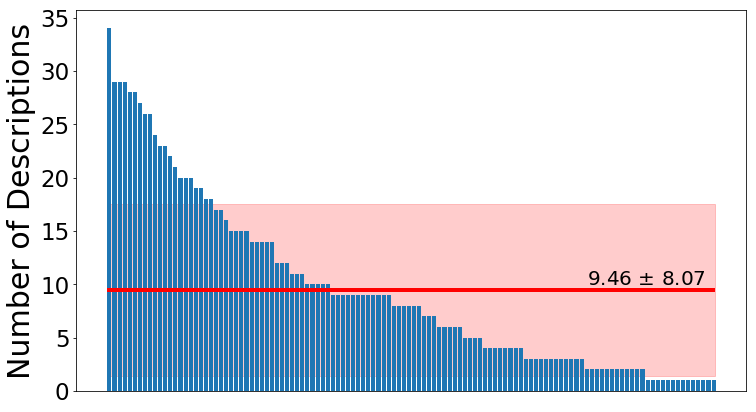

In [98]:
import matplotlib.pyplot as pltt

x = []
y = []

for relation in ordered_relation_descs_count:
    x.append(relation)
    y.append(ordered_relation_descs_count[relation])

y.sort(reverse=True)
fig = pltt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
pltt.bar(range(1, len(x)+1), height=y)
avg = np.mean(np.array(list(ordered_relation_descs_count.values())))
shader_mean = np.array([avg]*120)
stdev = np.std(np.array(list(ordered_relation_descs_count.values())))
shader_stdev = np.array([stdev]*120)
ax.annotate(r"{:.2f} $\pm$ {:.2f}".format(avg, stdev), xy=(95, 10), fontsize=20.0)
pltt.hlines(avg, 0.5, 120.25, colors='r', linestyles='solid', label='avg', linewidth=4.0)
pltt.fill_between(np.linspace(0.5, 120.25, 120), shader_mean-shader_stdev, shader_mean+shader_stdev, color="r", alpha=0.2)
#set parameters for tick labels
pltt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
pltt.tick_params(axis='y', which='major', labelsize=23)
pltt.ylabel('Number of Descriptions', fontsize=30)

pltt.show()

In [103]:
descriptions = set()

for relation in relation_names:
    with open(join_path([path_relation_descriptions, re.sub('/', '-', re.sub(' ', '_', relation)) + '.txt']), 'r', encoding='utf-8') as f:
        for line in f:
            descriptions.add(line.strip())

descriptions = list(descriptions)
print(len(descriptions))

print(descriptions[0])
print(len(tokenizer.tokenize(descriptions[0])))
print(tokenizer.tokenize(descriptions[0]))
descriptions_lengths = np.array([len(tokenizer.tokenize(description)) for description in descriptions])

print(np.mean(descriptions_lengths), np.std(descriptions_lengths))

1098
OBJECT_ENTITY is where the home games of SUBJECT_ENTITY are played
10
[OBJECT_ENTITY, is, where, the, home, games, of, SUBJECT_ENTITY, are, played]
7.373406193078324 1.8785781791722675


In [15]:
print(ordered_relation_descs_count)

{'airline hub': 9, 'architect': 29, 'architectural style': 3, 'author': 27, 'award received': 5, 'based on': 2, 'brother': 2, 'canonization status': 1, 'cast member': 10, 'cause of death': 23, 'chairperson': 1, 'characters': 1, 'child': 2, 'chromosome': 10, 'collection': 1, 'conferred by': 1, 'conflict': 20, 'connecting line': 11, 'constellation': 21, 'continent': 18, 'convicted of': 3, 'country': 22, 'country of citizenship': 16, 'country of origin': 6, 'creator': 7, 'crosses': 4, 'date of birth': 9, 'date of death': 20, 'date of official opening': 14, 'designer': 9, 'developer': 9, 'director': 23, 'discoverer or inventor': 15, 'dissolved or abolished': 9, 'distributor': 19, 'drafted by': 6, 'editor': 4, 'educated at': 8, 'employer': 1, 'end time': 1, 'father': 14, 'film editor': 17, 'found in taxon': 3, 'founder': 9, 'from fictional universe': 11, 'head of government': 4, 'headquarters location': 6, 'home venue': 29, 'illustrator': 4, 'inception': 26, 'industry': 1, 'instrument': 24,

In [19]:
from   tkinter import Tk
relations_list = list(ordered_relation_descs_count)

['airline hub', 'architect', 'architectural style', 'author', 'award received', 'based on', 'brother', 'canonization status', 'cast member', 'cause of death', 'chairperson', 'characters', 'child', 'chromosome', 'collection', 'conferred by', 'conflict', 'connecting line', 'constellation', 'continent', 'convicted of', 'country', 'country of citizenship', 'country of origin', 'creator', 'crosses', 'date of birth', 'date of death', 'date of official opening', 'designer', 'developer', 'director', 'discoverer or inventor', 'dissolved or abolished', 'distributor', 'drafted by', 'editor', 'educated at', 'employer', 'end time', 'father', 'film editor', 'found in taxon', 'founder', 'from fictional universe', 'head of government', 'headquarters location', 'home venue', 'illustrator', 'inception', 'industry', 'instrument', 'instrumentation', 'IUCN conservation status', 'language of work or name', 'languages spoken or written', 'league', 'license', 'licensed to broadcast to', 'located in the admini

In [22]:
# First half of relations

latex_header = r"\begin{tabular}{c|c}" + "\n"
latex_header += r"Relation & Number of Descriptions     \\ \hline" + "\n"


latex_body = r""

for l_num, relation in enumerate(relations_list[:60]):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"
    latex_body += r"{} & {} \\".format(relation, ordered_relation_descs_count[relation])

latex_footer = r"\end{tabular}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{tabular}{c|c}
Relation & Number of Descriptions     \\ \hline
airline hub & 9 \\\rowcolor[HTML]{EFEFEF} 
architect & 29 \\architectural style & 3 \\\rowcolor[HTML]{EFEFEF} 
author & 27 \\award received & 5 \\\rowcolor[HTML]{EFEFEF} 
based on & 2 \\brother & 2 \\\rowcolor[HTML]{EFEFEF} 
canonization status & 1 \\cast member & 10 \\\rowcolor[HTML]{EFEFEF} 
cause of death & 23 \\chairperson & 1 \\\rowcolor[HTML]{EFEFEF} 
characters & 1 \\child & 2 \\\rowcolor[HTML]{EFEFEF} 
chromosome & 10 \\collection & 1 \\\rowcolor[HTML]{EFEFEF} 
conferred by & 1 \\conflict & 20 \\\rowcolor[HTML]{EFEFEF} 
connecting line & 11 \\constellation & 21 \\\rowcolor[HTML]{EFEFEF} 
continent & 18 \\convicted of & 3 \\\rowcolor[HTML]{EFEFEF} 
country & 22 \\country of citizenship & 16 \\\rowcolor[HTML]{EFEFEF} 
country of origin & 6 \\creator & 7 \\\rowcolor[HTML]{EFEFEF} 
crosses & 4 \\date of birth & 9 \\\rowcolor[HTML]{EFEFEF} 
date of death & 20 \\date of official opening & 14 \\\rowcolor[HTML]{EFEFEF

In [23]:
# Second half of relations

latex_header = r"\begin{tabular}{c|c}" + "\n"
latex_header += r"Relation & Number of Descriptions     \\ \hline" + "\n"


latex_body = r""

for l_num, relation in enumerate(relations_list[60:]):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"
    latex_body += r"{} & {} \\".format(relation, ordered_relation_descs_count[relation])

latex_footer = r"\end{tabular}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{tabular}{c|c}
Relation & Number of Descriptions     \\ \hline
located next to body of water & 3 \\\rowcolor[HTML]{EFEFEF} 
located on astronomical body & 9 \\location of formation & 6 \\\rowcolor[HTML]{EFEFEF} 
lyrics by & 12 \\manner of death & 4 \\\rowcolor[HTML]{EFEFEF} 
manufacturer & 15 \\material used & 2 \\\rowcolor[HTML]{EFEFEF} 
medical condition & 18 \\member of political party & 7 \\\rowcolor[HTML]{EFEFEF} 
member of sports team & 15 \\military branch & 26 \\\rowcolor[HTML]{EFEFEF} 
military rank & 2 \\mother & 9 \\\rowcolor[HTML]{EFEFEF} 
mouth of the watercourse & 9 \\named after & 4 \\\rowcolor[HTML]{EFEFEF} 
narrative location & 2 \\native language & 10 \\\rowcolor[HTML]{EFEFEF} 
noble family & 3 \\noble title & 2 \\\rowcolor[HTML]{EFEFEF} 
nominated for & 2 \\occupant & 1 \\\rowcolor[HTML]{EFEFEF} 
occupation & 3 \\operating system & 1 \\\rowcolor[HTML]{EFEFEF} 
original network & 34 \\parent company & 3 \\\rowcolor[HTML]{EFEFEF} 
parent taxon & 5 \\participant o